In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

In [3]:
bird = 'B1240'
d = 32

In [4]:
#ratings = [1,2,3]
#ratings_str = ''.join([str(x) for x in ratings])

In [5]:
#sort_path =  '/mnt/cube/srrudrar/sorted/B1596/block4/continuous/Rhythm_FPGA-100.0/'#
#
#clusters = []
#for rating in ratings:
#    x = tu.get_clusters_by_rating(sort_path, rating)
#    clusters.extend(x)
#
#n_cells = len(clusters)

In [6]:
#np.save('/mnt/cube/srrudrar/temporal_model/units_to_process_B1596.npy',clusters)

### Load dsets

In [7]:
def kozlov_averaging(spec, n_rows, n_cols):
    '''
    Average rows and columns of spectrogram according to Kozlov & Gentner 2016 
    In Andrei's paper he averaged twice along rows(frequency bins) and three times
    across columns (time bins).

    n_rows specifies how many times to average rows pairwise, and n_cols specifies how many times
    to average columsn pairwise.
    '''
    spec_c = np.copy(spec)

    for idx in range(n_rows):
        spec_c = MNE.avg_pairwise(spec_c, axis=0)

    for idx in range(n_cols):
        spec_c = MNE.avg_pairwise(spec_c, axis=1)

    return spec_c

In [8]:
stim_spec1 = np.load('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/spec_test_{}.npy'.format(bird,d,d)) ###change
stim_resp = np.load('/mnt/cube/srrudrar/temporal_model/{}/32x32/stim_resp_32x32_{}/resp_test_{}.npy'.format(bird,d,d))###change

In [9]:
stim_spec1 = stim_spec1.reshape((np.shape(stim_spec1)[0],32,32))

In [10]:
np.shape(stim_spec1), np.shape(stim_resp)

((5706, 32, 32), (5706, 214, 32))

In [13]:
stim_spec = [kozlov_averaging(s,2,3).reshape((d,)) for s in stim_spec1]

In [14]:
np.shape(stim_spec), np.shape(stim_resp)

((5706, 32), (5706, 214, 32))

In [15]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=32, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [16]:
nsegbins = 32

In [17]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [18]:
np.shape(stim_mne), np.shape(resp_mne)

((5706, 32), (5706, 214))

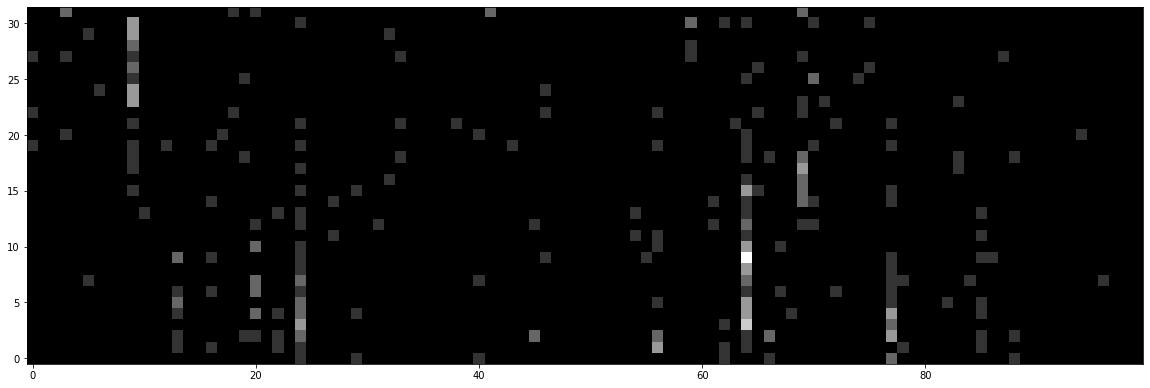

In [19]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [20]:
len_units = np.shape(resp_mne)[1]

In [21]:
units_to_process = list(np.load('/mnt/cube/srrudrar/temporal_model/units_to_process_{}.npy'.format(bird)))        ###change

In [22]:
exp_path = '/mnt/cube/srrudrar/raw_spec/{}/32x32/stim_resp_32x32_{}/test_set_mne1/'.format(bird,d)           ###change

In [23]:
# obtain all preprocessed datas

%matplotlib inline
sdim = d                                                                                                          ###change                                                                
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 
    1       0    0.155448
    2       0    0.153267
    3       0    0.153237
    4       0    0.151373
    5       0    0.150822
    6       0    0.147806
    7       0    0.146517
    8       0    0.146728
    9       1    0.145264
   10       0    0.145208
   11       0    0.144884
   12       0    0.144095
   13       0    0.143519
   14       0    0.143722
   15       1    0.143728
   16       2    0.143184
   17       0    0.143169
   18       0    0.142173
   19       0    0.141970
   20       0    0.142104
   21       1    0.141565
   22       0    0.141901
   23       1    0.142167
   24       2    0.142720
   25       3    0.142467
   26       4    0.141860
   27       5    0.141669
   28       6    0.141599
   29       7    0.140970
   30       0    0.140892
   31       0    0.140751
   32       0    0.140394
   33       0    0.139962
   34       0    0.139654
   35       0    0.139534
   36       0    0.139107
   37       0    0.138982
   38       

   25       2    0.128949
   26       0    0.128642
   27       0    0.129594
   28       1    0.128912
   29       2    0.127766
   30       0    0.127771
   31       1    0.128134
   32       2    0.128267
   33       3    0.128588
   34       4    0.128656
   35       5    0.128101
   36       6    0.127440
   37       0    0.127467
   38       1    0.128128
   39       2    0.127653
   40       3    0.128928
   41       4    0.127738
   42       5    0.127945
   43       6    0.128703
   44       7    0.129003
   45       8    0.128076
   46       9    0.127657
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.171022
    2       0    0.168196
    3       0    0.169957
    4       1    0.166948
    5       0    0.167480
    6       1    0.165836
    7       0    0.164060
    8       0    0.162809
    9       0    0.160816
   10       0    0.160704
   11       0    0.161849
   12       1    0.161536
   13       2    0.161174
   14       3    0.160512
   15       

   42       3    0.084910
   43       0    0.084846
   44       0    0.084771
   45       0    0.084706
   46       0    0.084780
   47       1    0.084752
   48       2    0.084775
   49       3    0.084666
   50       0    0.084564
   51       0    0.084539
   52       0    0.084596
   53       1    0.084579
   54       2    0.084511
   55       0    0.084637
   56       1    0.084636
   57       2    0.084584
   58       3    0.084533
   59       4    0.084555
   60       5    0.084495
   61       0    0.084472
   62       0    0.084496
   63       1    0.084524
   64       2    0.084464
   65       0    0.084803
   66       1    0.084880
   67       2    0.085191
   68       3    0.085440
   69       4    0.086000
   70       5    0.086794
   71       6    0.087107
   72       7    0.087148
   73       8    0.087383
   74       9    0.087437
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.092726
    2       0    0.092496
    3       0    0.091921
    4       

   41       0    0.190328
   42       0    0.190561
   43       1    0.190529
   44       2    0.190437
   45       3    0.190479
   46       4    0.190378
   47       5    0.190140
   48       0    0.190231
   49       1    0.190638
   50       2    0.190828
   51       3    0.190964
   52       4    0.191214
   53       5    0.191345
   54       6    0.190735
   55       7    0.190527
   56       8    0.190643
   57       9    0.190479
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.192055
    2       0    0.192163
    3       0    0.190960
    4       0    0.189650
    5       0    0.190497
    6       1    0.190798
    7       2    0.189681
    8       3    0.188960
    9       0    0.188515
   10       0    0.188543
   11       1    0.189591
   12       2    0.190115
   13       3    0.188162
   14       0    0.187380
   15       0    0.186567
   16       0    0.186530
   17       0    0.186317
   18       0    0.186295
   19       0    0.186518
   20       

   38       6    0.090799
   39       7    0.090659
   40       0    0.090657
   41       0    0.090757
   42       1    0.090811
   43       2    0.090850
   44       3    0.090956
   45       4    0.090979
   46       5    0.090992
   47       6    0.090928
   48       7    0.090888
   49       8    0.090878
   50       9    0.090940
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.097585
    2       0    0.098448
    3       0    0.097184
    4       0    0.096787
    5       0    0.095844
    6       0    0.095638
    7       0    0.095661
    8       1    0.095284
    9       0    0.094927
   10       0    0.094553
   11       0    0.094167
   12       0    0.093867
   13       0    0.093176
   14       0    0.093185
   15       1    0.093190
   16       2    0.093060
   17       0    0.092953
   18       0    0.092592
   19       0    0.092449
   20       0    0.092209
   21       0    0.092173
   22       0    0.092147
   23       0    0.091963
   24       

   33       2    0.117686
   34       0    0.117658
   35       0    0.117570
   36       0    0.117572
   37       1    0.117474
   38       0    0.117512
   39       1    0.117028
   40       0    0.116861
   41       0    0.116980
   42       1    0.117005
   43       2    0.116850
   44       0    0.116570
   45       0    0.116423
   46       0    0.116244
   47       0    0.116180
   48       0    0.116172
   49       0    0.115998
   50       0    0.115923
   51       0    0.115746
   52       0    0.115309
   53       0    0.115251
   54       0    0.115239
   55       0    0.115470
   56       1    0.115551
   57       2    0.115688
   58       3    0.115525
   59       4    0.115253
   60       5    0.115233
   61       0    0.115128
   62       0    0.115017
   63       0    0.114951
   64       0    0.114899
   65       0    0.114784
   66       0    0.114763
   67       0    0.114730
   68       0    0.114822
   69       1    0.114849
   70       2    0.114879
   71       

   32       1    0.124920
   33       2    0.124572
   34       0    0.124758
   35       1    0.124220
   36       0    0.124609
   37       1    0.123990
   38       0    0.123350
   39       0    0.123594
   40       1    0.123962
   41       2    0.124086
   42       3    0.123794
   43       4    0.123752
   44       5    0.124031
   45       6    0.123956
   46       7    0.123817
   47       8    0.124257
   48       9    0.124599
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.142160
    2       0    0.142187
    3       0    0.139897
    4       0    0.139115
    5       0    0.138754
    6       0    0.137739
    7       0    0.137925
    8       1    0.137338
    9       0    0.137604
   10       1    0.136859
   11       0    0.136075
   12       0    0.135905
   13       0    0.135262
   14       0    0.134302
   15       0    0.133857
   16       0    0.133663
   17       0    0.133535
   18       0    0.133580
   19       1    0.133568
   20       

   49       0    0.279097
   50       0    0.279416
   51       1    0.279479
   52       2    0.279282
   53       3    0.279218
   54       4    0.279267
   55       5    0.279053
   56       0    0.279089
   57       1    0.279143
   58       2    0.279465
   59       3    0.279728
   60       4    0.279591
   61       5    0.279352
   62       6    0.279390
   63       7    0.279260
   64       8    0.279113
   65       9    0.278862
   66       0    0.278940
   67       1    0.279152
   68       2    0.278963
   69       3    0.278773
   70       0    0.278903
   71       1    0.278748
   72       0    0.278553
   73       0    0.278399
   74       0    0.278549
   75       1    0.278547
   76       2    0.278308
   77       0    0.278321
   78       1    0.278431
   79       2    0.278415
   80       3    0.278651
   81       4    0.278671
   82       5    0.278568
   83       6    0.278714
   84       7    0.279485
   85       8    0.279529
   86       9    0.278718
minimum of t

   24       6    0.107450
   25       7    0.107133
   26       8    0.106793
   27       0    0.107038
   28       1    0.107266
   29       2    0.107756
   30       3    0.107913
   31       4    0.108434
   32       5    0.108417
   33       6    0.108085
   34       7    0.108033
   35       8    0.108092
   36       9    0.107978
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.050317
    2       0    0.047859
    3       0    0.046618
    4       0    0.046349
    5       0    0.046104
    6       0    0.046695
    7       1    0.045755
    8       0    0.045829
    9       1    0.045440
   10       0    0.045361
   11       0    0.045582
   12       1    0.045012
   13       0    0.044891
   14       0    0.045125
   15       1    0.044880
   16       0    0.044694
   17       0    0.044862
   18       1    0.044788
   19       2    0.045096
   20       3    0.045194
   21       4    0.044110
   22       0    0.043737
   23       0    0.044354
   24       

   47       6    0.168437
   48       0    0.168510
   49       1    0.168490
   50       2    0.168943
   51       3    0.168981
   52       4    0.169261
   53       5    0.169411
   54       6    0.169858
   55       7    0.170195
   56       8    0.170180
   57       9    0.170282
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.161865
    2       0    0.161312
    3       0    0.160979
    4       0    0.160472
    5       0    0.160275
    6       0    0.160299
    7       1    0.159760
    8       0    0.159705
    9       0    0.159824
   10       1    0.159547
   11       0    0.159104
   12       0    0.159138
   13       1    0.159300
   14       2    0.158871
   15       0    0.158034
   16       0    0.158242
   17       1    0.157827
   18       0    0.157606
   19       0    0.157416
   20       0    0.157617
   21       1    0.157607
   22       2    0.157805
   23       3    0.157690
   24       4    0.157472
   25       5    0.157306
   26       

   19       0    0.611414
   20       1    0.611378
   21       2    0.611319
   22       0    0.611132
   23       0    0.610989
   24       0    0.610848
   25       0    0.610847
   26       0    0.610777
   27       0    0.610716
   28       0    0.610716
   29       1    0.610797
   30       2    0.610774
   31       3    0.610803
   32       4    0.610859
   33       5    0.610803
   34       6    0.610572
   35       0    0.610351
   36       0    0.610346
   37       0    0.610242
   38       0    0.610199
   39       0    0.610203
   40       1    0.610222
   41       2    0.610214
   42       3    0.610248
   43       4    0.610213
   44       5    0.610104
   45       0    0.610047
   46       0    0.609972
   47       0    0.609979
   48       1    0.609995
   49       2    0.609967
   50       0    0.609974
   51       1    0.609986
   52       2    0.609945
   53       0    0.610021
   54       1    0.610028
   55       2    0.609984
   56       3    0.610024
   57       

   64       3    0.606882
   65       4    0.606844
   66       5    0.606869
   67       6    0.606936
   68       7    0.607006
   69       8    0.606943
   70       9    0.606817
   71       0    0.606618
   72       0    0.606570
   73       0    0.606647
   74       1    0.606665
   75       2    0.606667
   76       3    0.606644
   77       4    0.606581
   78       5    0.606579
   79       6    0.606526
   80       0    0.606535
   81       1    0.606656
   82       2    0.606705
   83       3    0.606658
   84       4    0.606550
   85       5    0.606508
   86       0    0.606402
   87       0    0.606261
   88       0    0.606181
   89       0    0.606196
   90       1    0.606179
   91       0    0.606163
   92       0    0.606111
   93       0    0.606108
   94       0    0.606070
   95       0    0.606024
   96       0    0.606000
   97       0    0.606016
   98       1    0.605950
   99       0    0.605900
  100       0    0.605801
  101       0    0.605831
  102       

  114       8    0.136314
  115       9    0.136266
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.153048
    2       0    0.150837
    3       0    0.150995
    4       1    0.149083
    5       0    0.149173
    6       1    0.148383
    7       0    0.148093
    8       0    0.148827
    9       1    0.148901
   10       2    0.148108
   11       3    0.147396
   12       0    0.147066
   13       0    0.147302
   14       1    0.146467
   15       0    0.146109
   16       0    0.145435
   17       0    0.145300
   18       0    0.145060
   19       0    0.144873
   20       0    0.145006
   21       1    0.144923
   22       2    0.145046
   23       3    0.144585
   24       0    0.144395
   25       0    0.144077
   26       0    0.144484
   27       1    0.143502
   28       0    0.143543
   29       1    0.143380
   30       0    0.143052
   31       0    0.142802
   32       0    0.142790
   33       0    0.142806
   34       1    0.142589
   35       

   44       0    0.429474
   45       1    0.429402
   46       2    0.429446
   47       3    0.429477
   48       4    0.429401
   49       5    0.429387
   50       0    0.429283
   51       0    0.429215
   52       0    0.429145
   53       0    0.429179
   54       1    0.429118
   55       0    0.429167
   56       1    0.429492
   57       2    0.429422
   58       3    0.429460
   59       4    0.429732
   60       5    0.429877
   61       6    0.430053
   62       7    0.430353
   63       8    0.430306
   64       9    0.430332
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.444265
    2       0    0.441309
    3       0    0.438731
    4       0    0.438367
    5       0    0.438326
    6       0    0.438246
    7       0    0.437051
    8       0    0.437369
    9       1    0.436665
   10       0    0.436472
   11       0    0.435388
   12       0    0.435082
   13       0    0.435279
   14       1    0.435424
   15       2    0.435194
   16       

   44       1    0.246909
   45       2    0.246833
   46       0    0.246738
   47       0    0.246759
   48       1    0.246820
   49       2    0.246811
   50       3    0.246583
   51       0    0.246505
   52       0    0.246321
   53       0    0.246307
   54       0    0.246441
   55       1    0.246472
   56       2    0.246371
   57       3    0.246387
   58       4    0.246393
   59       5    0.246389
   60       6    0.246412
   61       7    0.246418
   62       8    0.246358
   63       9    0.246282
   64       0    0.246281
   65       0    0.246262
   66       0    0.246269
   67       1    0.246299
   68       2    0.246316
   69       3    0.246365
   70       4    0.246365
   71       5    0.246318
   72       6    0.246256
   73       0    0.246220
   74       0    0.246156
   75       0    0.246040
   76       0    0.246059
   77       1    0.246172
   78       2    0.246158
   79       3    0.246166
   80       4    0.246142
   81       5    0.246271
   82       

    2       0    0.083231
    3       0    0.082648
    4       0    0.080008
    5       0    0.079638
    6       0    0.080819
    7       1    0.080219
    8       2    0.079018
    9       0    0.079818
   10       1    0.079239
   11       2    0.079741
   12       3    0.078610
   13       0    0.077718
   14       0    0.077553
   15       0    0.077487
   16       0    0.079021
   17       1    0.078428
   18       2    0.078186
   19       3    0.078603
   20       4    0.078811
   21       5    0.077799
   22       6    0.078089
   23       7    0.078579
   24       8    0.078661
   25       9    0.078831
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.069632
    2       0    0.069454
    3       0    0.067399
    4       0    0.065870
    5       0    0.067590
    6       1    0.069167
    7       2    0.066820
    8       3    0.066538
    9       4    0.067715
   10       5    0.067732
   11       6    0.065482
   12       0    0.065619
   13       

   36       1    0.568703
   37       2    0.568543
   38       0    0.568620
   39       1    0.568522
   40       0    0.568571
   41       1    0.568595
   42       2    0.568395
   43       0    0.568292
   44       0    0.568424
   45       1    0.568210
   46       0    0.567977
   47       0    0.567523
   48       0    0.567706
   49       1    0.567468
   50       0    0.567605
   51       1    0.567296
   52       0    0.567846
   53       1    0.567804
   54       2    0.568355
   55       3    0.568357
   56       4    0.567990
   57       5    0.567943
   58       6    0.568173
   59       7    0.567782
   60       8    0.567620
   61       9    0.567558
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.592820
    2       0    0.591208
    3       0    0.587312
    4       0    0.586746
    5       0    0.583586
    6       0    0.578590
    7       0    0.576731
    8       0    0.575603
    9       0    0.575080
   10       0    0.573661
   11       

   24       0    0.135951
   25       0    0.135784
   26       0    0.135868
   27       1    0.135869
   28       2    0.136237
   29       3    0.135945
   30       4    0.135676
   31       0    0.135647
   32       0    0.135560
   33       0    0.135443
   34       0    0.135391
   35       0    0.135366
   36       0    0.135334
   37       0    0.135245
   38       0    0.135237
   39       0    0.135060
   40       0    0.134971
   41       0    0.134889
   42       0    0.134868
   43       0    0.134651
   44       0    0.134802
   45       1    0.135036
   46       2    0.134731
   47       3    0.134662
   48       4    0.134536
   49       0    0.134384
   50       0    0.134452
   51       1    0.134455
   52       2    0.134415
   53       3    0.134317
   54       0    0.134245
   55       0    0.134128
   56       0    0.134053
   57       0    0.134114
   58       1    0.134137
   59       2    0.134182
   60       3    0.134180
   61       4    0.134232
   62       

    2       0    0.061486
    3       0    0.057756
    4       0    0.057555
    5       0    0.056550
    6       0    0.056869
    7       1    0.056839
    8       2    0.055664
    9       0    0.055620
   10       0    0.055756
   11       1    0.056286
   12       2    0.056249
   13       3    0.055807
   14       4    0.055597
   15       0    0.055483
   16       0    0.055370
   17       0    0.055583
   18       1    0.055325
   19       0    0.055376
   20       1    0.055535
   21       2    0.055494
   22       3    0.055327
   23       4    0.055514
   24       5    0.055919
   25       6    0.056639
   26       7    0.056401
   27       8    0.056099
   28       9    0.056040
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.304308
    2       0    0.299716
    3       0    0.297304
    4       0    0.295526
    5       0    0.294030
    6       0    0.292874
    7       0    0.291065
    8       0    0.290336
    9       0    0.289398
   10       

   44       0    0.299649
   45       0    0.299620
   46       0    0.299555
   47       0    0.299499
   48       0    0.299597
   49       1    0.299951
   50       2    0.300352
   51       3    0.300145
   52       4    0.299740
   53       5    0.299528
   54       6    0.299488
   55       0    0.299471
   56       0    0.299340
   57       0    0.299284
   58       0    0.299272
   59       0    0.299300
   60       1    0.299279
   61       2    0.299271
   62       0    0.299330
   63       1    0.299389
   64       2    0.299373
   65       3    0.299240
   66       0    0.299167
   67       0    0.299373
   68       1    0.299281
   69       2    0.299195
   70       3    0.299137
   71       0    0.299106
   72       0    0.299078
   73       0    0.299048
   74       0    0.298992
   75       0    0.298981
   76       0    0.299054
   77       1    0.299272
   78       2    0.299295
   79       3    0.299160
   80       4    0.299411
   81       5    0.299429
   82       

   49       0    0.241422
   50       0    0.241359
   51       0    0.241346
   52       0    0.241326
   53       0    0.241278
   54       0    0.241166
   55       0    0.240900
   56       0    0.240633
   57       0    0.240500
   58       0    0.240447
   59       0    0.240429
   60       0    0.240102
   61       0    0.239946
   62       0    0.239972
   63       1    0.239877
   64       0    0.239782
   65       0    0.239672
   66       0    0.239703
   67       1    0.239709
   68       2    0.239775
   69       3    0.239726
   70       4    0.239765
   71       5    0.239809
   72       6    0.239732
   73       7    0.239652
   74       0    0.239672
   75       1    0.239622
   76       0    0.239590
   77       0    0.239570
   78       0    0.239563
   79       0    0.239513
   80       0    0.239489
   81       0    0.239505
   82       1    0.239509
   83       2    0.239387
   84       0    0.239345
   85       0    0.239427
   86       1    0.239368
   87       

   17       0    0.412565
   18       1    0.412309
   19       0    0.412401
   20       1    0.411983
   21       0    0.411832
   22       0    0.411904
   23       1    0.411619
   24       0    0.411831
   25       1    0.411768
   26       2    0.411610
   27       0    0.411222
   28       0    0.411176
   29       0    0.411084
   30       0    0.410970
   31       0    0.411158
   32       1    0.411173
   33       2    0.410961
   34       0    0.410966
   35       1    0.411129
   36       2    0.411048
   37       3    0.410893
   38       0    0.410710
   39       0    0.410725
   40       1    0.410837
   41       2    0.410325
   42       0    0.410111
   43       0    0.410556
   44       1    0.410095
   45       0    0.409685
   46       0    0.409653
   47       0    0.409737
   48       1    0.409789
   49       2    0.409693
   50       3    0.409772
   51       4    0.409709
   52       5    0.410001
   53       6    0.409981
   54       7    0.409212
   55       

   25       6    0.078255
   26       7    0.077823
   27       0    0.077614
   28       0    0.077283
   29       0    0.077255
   30       0    0.077233
   31       0    0.077086
   32       0    0.077348
   33       1    0.077337
   34       2    0.077226
   35       3    0.077065
   36       0    0.076910
   37       0    0.076764
   38       0    0.076638
   39       0    0.076641
   40       1    0.076579
   41       0    0.076621
   42       1    0.076572
   43       0    0.076566
   44       0    0.076657
   45       1    0.076587
   46       2    0.076541
   47       0    0.076347
   48       0    0.076183
   49       0    0.075878
   50       0    0.075896
   51       1    0.075902
   52       2    0.076101
   53       3    0.076183
   54       4    0.076053
   55       5    0.075964
   56       6    0.075865
   57       0    0.075348
   58       0    0.075380
   59       1    0.075552
   60       2    0.075702
   61       3    0.075780
   62       4    0.075869
   63       

   20       0    0.123815
   21       1    0.123084
   22       0    0.122845
   23       0    0.123142
   24       1    0.123168
   25       2    0.122879
   26       3    0.123106
   27       4    0.123524
   28       5    0.123498
   29       6    0.123698
   30       7    0.123076
   31       8    0.123326
   32       9    0.123552
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.123152
    2       0    0.120706
    3       0    0.118026
    4       0    0.117315
    5       0    0.116802
    6       0    0.115762
    7       0    0.115433
    8       0    0.115411
    9       0    0.115247
   10       0    0.114785
   11       0    0.114523
   12       0    0.114359
   13       0    0.114357
   14       0    0.114250
   15       0    0.114323
   16       1    0.114396
   17       2    0.114388
   18       3    0.113885
   19       0    0.113705
   20       0    0.113163
   21       0    0.113153
   22       0    0.112747
   23       0    0.112898
   24       

    1       0    0.258429
    2       0    0.255264
    3       0    0.249766
    4       0    0.247080
    5       0    0.246470
    6       0    0.245228
    7       0    0.243479
    8       0    0.240587
    9       0    0.239199
   10       0    0.237283
   11       0    0.236576
   12       0    0.236274
   13       0    0.235243
   14       0    0.234571
   15       0    0.233211
   16       0    0.232951
   17       0    0.232043
   18       0    0.231163
   19       0    0.230028
   20       0    0.229945
   21       0    0.229308
   22       0    0.229068
   23       0    0.228932
   24       0    0.228935
   25       1    0.228430
   26       0    0.228442
   27       1    0.228358
   28       0    0.228536
   29       1    0.228791
   30       2    0.229236
   31       3    0.228249
   32       0    0.227908
   33       0    0.227347
   34       0    0.227410
   35       1    0.227257
   36       0    0.226725
   37       0    0.226394
   38       0    0.226208
   39       

   43       0    0.573074
   44       1    0.573010
   45       0    0.573014
   46       1    0.572926
   47       0    0.572900
   48       0    0.572937
   49       1    0.572892
   50       0    0.572773
   51       0    0.572584
   52       0    0.572561
   53       0    0.572451
   54       0    0.572402
   55       0    0.572428
   56       1    0.572459
   57       2    0.572217
   58       0    0.572122
   59       0    0.572032
   60       0    0.572117
   61       1    0.572076
   62       2    0.572124
   63       3    0.571633
   64       0    0.571677
   65       1    0.571506
   66       0    0.571552
   67       1    0.571496
   68       0    0.571607
   69       1    0.571607
   70       2    0.572032
   71       3    0.571982
   72       4    0.572022
   73       5    0.571825
   74       6    0.572090
   75       7    0.572175
   76       8    0.572200
   77       9    0.572347
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.601330
    2       

   47       8    0.200540
   48       9    0.200447
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.198968
    2       0    0.198446
    3       0    0.197983
    4       0    0.198152
    5       1    0.197838
    6       0    0.198045
    7       1    0.197595
    8       0    0.197573
    9       0    0.197120
   10       0    0.196812
   11       0    0.196448
   12       0    0.196130
   13       0    0.196117
   14       0    0.195347
   15       0    0.195268
   16       0    0.194844
   17       0    0.194707
   18       0    0.194583
   19       0    0.194384
   20       0    0.194365
   21       0    0.194251
   22       0    0.194269
   23       1    0.194297
   24       2    0.194266
   25       3    0.194252
   26       4    0.194232
   27       0    0.194189
   28       0    0.193983
   29       0    0.193964
   30       0    0.193881
   31       0    0.193762
   32       0    0.193750
   33       0    0.193836
   34       1    0.193959
   35       

   26       8    0.153141
   27       9    0.153714
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.171976
    2       0    0.169498
    3       0    0.168704
    4       0    0.169093
    5       1    0.169518
    6       2    0.169167
    7       3    0.169401
    8       4    0.168798
    9       5    0.167755
   10       0    0.166487
   11       0    0.166436
   12       0    0.166373
   13       0    0.166203
   14       0    0.165903
   15       0    0.165649
   16       0    0.165724
   17       1    0.165776
   18       2    0.165850
   19       3    0.164845
   20       0    0.164231
   21       0    0.164297
   22       1    0.164263
   23       2    0.164202
   24       0    0.164341
   25       1    0.164326
   26       2    0.164233
   27       3    0.163962
   28       0    0.163741
   29       0    0.163602
   30       0    0.163622
   31       1    0.163654
   32       2    0.163761
   33       3    0.163919
   34       4    0.163793
   35       

    3       0    0.660017
    4       1    0.658479
    5       0    0.657017
    6       0    0.656483
    7       0    0.655945
    8       0    0.655828
    9       0    0.655689
   10       0    0.654824
   11       0    0.654282
   12       0    0.654322
   13       1    0.654270
   14       0    0.653911
   15       0    0.653799
   16       0    0.653602
   17       0    0.653347
   18       0    0.653233
   19       0    0.652998
   20       0    0.652803
   21       0    0.652634
   22       0    0.652523
   23       0    0.652467
   24       0    0.652439
   25       0    0.652302
   26       0    0.652275
   27       0    0.652041
   28       0    0.651984
   29       0    0.651940
   30       0    0.651892
   31       0    0.651850
   32       0    0.651847
   33       0    0.651858
   34       1    0.651852
   35       2    0.651895
   36       3    0.651950
   37       4    0.651838
   38       0    0.651808
   39       0    0.651762
   40       0    0.651746
   41       

   48       5    0.592781
   49       6    0.592703
   50       7    0.592623
   51       8    0.592486
   52       9    0.591985
   53       0    0.591845
   54       0    0.592042
   55       1    0.592147
   56       2    0.592061
   57       3    0.592137
   58       4    0.592210
   59       5    0.592524
   60       6    0.592735
   61       7    0.593106
   62       8    0.593090
   63       9    0.592793
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.612149
    2       0    0.608534
    3       0    0.606148
    4       0    0.602280
    5       0    0.601569
    6       0    0.601126
    7       0    0.600533
    8       0    0.599598
    9       0    0.598861
   10       0    0.598603
   11       0    0.598391
   12       0    0.597706
   13       0    0.597434
   14       0    0.596899
   15       0    0.596312
   16       0    0.596338
   17       1    0.596212
   18       0    0.595946
   19       0    0.595854
   20       0    0.595851
   21       

   33       1    0.202375
   34       2    0.202125
   35       3    0.201968
   36       0    0.201674
   37       0    0.201776
   38       1    0.201989
   39       2    0.201972
   40       3    0.201739
   41       4    0.201392
   42       0    0.201507
   43       1    0.201863
   44       2    0.201838
   45       3    0.201827
   46       4    0.201381
   47       0    0.201150
   48       0    0.201031
   49       0    0.201053
   50       1    0.201069
   51       2    0.200947
   52       0    0.200803
   53       0    0.200835
   54       1    0.200293
   55       0    0.199913
   56       0    0.199818
   57       0    0.200425
   58       1    0.201192
   59       2    0.200356
   60       3    0.199960
   61       4    0.199810
   62       0    0.199253
   63       0    0.198743
   64       0    0.198787
   65       1    0.198859
   66       2    0.199086
   67       3    0.199083
   68       4    0.199046
   69       5    0.199020
   70       6    0.199159
   71       

   10       2    0.148251
   11       3    0.147347
   12       0    0.147242
   13       0    0.147017
   14       0    0.147096
   15       1    0.147980
   16       2    0.149289
   17       3    0.147473
   18       4    0.147370
   19       5    0.147318
   20       6    0.146686
   21       0    0.146086
   22       0    0.145869
   23       0    0.146393
   24       1    0.146571
   25       2    0.146773
   26       3    0.147340
   27       4    0.147613
   28       5    0.146940
   29       6    0.146418
   30       7    0.145832
   31       0    0.145619
   32       0    0.145511
   33       0    0.145714
   34       1    0.146173
   35       2    0.146563
   36       3    0.146132
   37       4    0.146001
   38       5    0.145763
   39       6    0.145707
   40       7    0.145706
   41       8    0.146172
   42       9    0.146037
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.151023
    2       0    0.148068
    3       0    0.146658
    4       

   10       0    0.139404
   11       0    0.139169
   12       0    0.139301
   13       1    0.139296
   14       2    0.138799
   15       0    0.138559
   16       0    0.138131
   17       0    0.138252
   18       1    0.138677
   19       2    0.138959
   20       3    0.138233
   21       4    0.137715
   22       0    0.137532
   23       0    0.137556
   24       1    0.137695
   25       2    0.137485
   26       0    0.137363
   27       0    0.137522
   28       1    0.137577
   29       2    0.137295
   30       0    0.137201
   31       0    0.137218
   32       1    0.137180
   33       0    0.137019
   34       0    0.137171
   35       1    0.137254
   36       2    0.136851
   37       0    0.136834
   38       0    0.137332
   39       1    0.137811
   40       2    0.138000
   41       3    0.138211
   42       4    0.138007
   43       5    0.137804
   44       6    0.137496
   45       7    0.137313
   46       8    0.136993
   47       9    0.137112
minimum of t

    1       0    0.457389
    2       0    0.451395
    3       0    0.450923
    4       0    0.448453
    5       0    0.447894
    6       0    0.445425
    7       0    0.444239
    8       0    0.442622
    9       0    0.441789
   10       0    0.441109
   11       0    0.440479
   12       0    0.440399
   13       0    0.439433
   14       0    0.439027
   15       0    0.438412
   16       0    0.438263
   17       0    0.438295
   18       1    0.438163
   19       0    0.438105
   20       0    0.438242
   21       1    0.437694
   22       0    0.437372
   23       0    0.437487
   24       1    0.437407
   25       2    0.436622
   26       0    0.436271
   27       0    0.436185
   28       0    0.436436
   29       1    0.436366
   30       2    0.436250
   31       3    0.436726
   32       4    0.436825
   33       5    0.436740
   34       6    0.436690
   35       7    0.436292
   36       8    0.435948
   37       0    0.435819
   38       0    0.435747
   39       

   28       0    0.441423
   29       0    0.441533
   30       1    0.441456
   31       2    0.441248
   32       0    0.441157
   33       0    0.441215
   34       1    0.441251
   35       2    0.441256
   36       3    0.440999
   37       0    0.440857
   38       0    0.440555
   39       0    0.440501
   40       0    0.440668
   41       1    0.440484
   42       0    0.440768
   43       1    0.440659
   44       2    0.440663
   45       3    0.440383
   46       0    0.440388
   47       1    0.440291
   48       0    0.440127
   49       0    0.440242
   50       1    0.440284
   51       2    0.440239
   52       3    0.440317
   53       4    0.439943
   54       0    0.439873
   55       0    0.439511
   56       0    0.439404
   57       0    0.439494
   58       1    0.439614
   59       2    0.439581
   60       3    0.439500
   61       4    0.439501
   62       5    0.439409
   63       6    0.439383
   64       0    0.439448
   65       1    0.439501
   66       

   25       2    0.633136
   26       0    0.632948
   27       0    0.632844
   28       0    0.632581
   29       0    0.632584
   30       1    0.632493
   31       0    0.632685
   32       1    0.632749
   33       2    0.632514
   34       3    0.632585
   35       4    0.632339
   36       0    0.632395
   37       1    0.632246
   38       0    0.632201
   39       0    0.631840
   40       0    0.631859
   41       1    0.631650
   42       0    0.631226
   43       0    0.631460
   44       1    0.631089
   45       0    0.630915
   46       0    0.630983
   47       1    0.630715
   48       0    0.630855
   49       1    0.630638
   50       0    0.631418
   51       1    0.631668
   52       2    0.631115
   53       3    0.631265
   54       4    0.631120
   55       5    0.630986
   56       6    0.630972
   57       7    0.631062
   58       8    0.631022
   59       9    0.630994
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.156272
    2       

   21       0    0.507762
   22       1    0.507504
   23       0    0.507151
   24       0    0.506361
   25       0    0.506334
   26       0    0.506130
   27       0    0.505613
   28       0    0.505718
   29       1    0.505664
   30       2    0.505574
   31       0    0.505592
   32       1    0.504887
   33       0    0.504756
   34       0    0.504655
   35       0    0.504280
   36       0    0.504241
   37       0    0.504330
   38       1    0.504238
   39       0    0.503968
   40       0    0.503958
   41       0    0.504001
   42       1    0.503716
   43       0    0.503670
   44       0    0.503863
   45       1    0.503863
   46       2    0.503506
   47       0    0.503576
   48       1    0.503530
   49       2    0.503519
   50       3    0.503207
   51       0    0.503038
   52       0    0.503109
   53       1    0.503103
   54       2    0.503237
   55       3    0.503214
   56       4    0.503197
   57       5    0.503317
   58       6    0.503150
   59       

   43       0    0.515652
   44       0    0.515749
   45       1    0.515744
   46       2    0.515558
   47       0    0.515435
   48       0    0.515376
   49       0    0.515385
   50       1    0.515519
   51       2    0.515255
   52       0    0.515132
   53       0    0.514935
   54       0    0.514761
   55       0    0.514581
   56       0    0.514592
   57       1    0.514465
   58       0    0.514412
   59       0    0.514473
   60       1    0.514455
   61       2    0.514389
   62       0    0.514408
   63       1    0.514424
   64       2    0.514403
   65       3    0.514396
   66       4    0.514424
   67       5    0.514427
   68       6    0.514538
   69       7    0.514473
   70       8    0.515111
   71       9    0.515154
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.411648
    2       0    0.406399
    3       0    0.406299
    4       0    0.404990
    5       0    0.403343
    6       0    0.402266
    7       0    0.402175
    8       

   92       1    0.380028
   93       2    0.380006
   94       3    0.379953
   95       0    0.379901
   96       0    0.379904
   97       1    0.379912
   98       2    0.379778
   99       0    0.379749
  100       0    0.379782
  101       1    0.379839
  102       2    0.379907
  103       3    0.379844
  104       4    0.379784
  105       5    0.379683
  106       0    0.379752
  107       1    0.379774
  108       2    0.379899
  109       3    0.379908
  110       4    0.379969
  111       5    0.380260
  112       6    0.380414
  113       7    0.380461
  114       8    0.380444
  115       9    0.380352
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.143211
    2       0    0.137431
    3       0    0.132968
    4       0    0.130439
    5       0    0.128440
    6       0    0.127336
    7       0    0.126992
    8       0    0.126608
    9       0    0.126384
   10       0    0.124852
   11       0    0.124485
   12       0    0.123886
   13       

   74       4    0.034442
   75       5    0.034397
   76       6    0.034463
   77       7    0.034495
   78       8    0.034474
   79       9    0.034474
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.045377
    2       0    0.043782
    3       0    0.042041
    4       0    0.040989
    5       0    0.040044
    6       0    0.038917
    7       0    0.039050
    8       1    0.038849
    9       0    0.038471
   10       0    0.038576
   11       1    0.038898
   12       2    0.038496
   13       3    0.038454
   14       0    0.038040
   15       0    0.038298
   16       1    0.038169
   17       2    0.037809
   18       0    0.037937
   19       1    0.037968
   20       2    0.037671
   21       0    0.037626
   22       0    0.037774
   23       1    0.037703
   24       2    0.037692
   25       3    0.037595
   26       0    0.037713
   27       1    0.037462
   28       0    0.037262
   29       0    0.037281
   30       1    0.037405
   31       

   37       0    0.191581
   38       0    0.191752
   39       1    0.192011
   40       2    0.192313
   41       3    0.191771
   42       4    0.191621
   43       5    0.191527
   44       0    0.191246
   45       0    0.191282
   46       1    0.191247
   47       2    0.191229
   48       0    0.191068
   49       0    0.191023
   50       0    0.191144
   51       1    0.191082
   52       2    0.191291
   53       3    0.191465
   54       4    0.191333
   55       5    0.190760
   56       0    0.191084
   57       1    0.191556
   58       2    0.191804
   59       3    0.190921
   60       4    0.190612
   61       0    0.190281
   62       0    0.190214
   63       0    0.190721
   64       1    0.190651
   65       2    0.190409
   66       3    0.190238
   67       4    0.190191
   68       0    0.190421
   69       1    0.190478
   70       2    0.190508
   71       3    0.190495
   72       4    0.190729
   73       5    0.190854
   74       6    0.190782
   75       

   91       3    0.460431
   92       0    0.460434
   93       1    0.460567
   94       2    0.460465
   95       3    0.460397
   96       0    0.460451
   97       1    0.460446
   98       2    0.460410
   99       3    0.460457
  100       4    0.460427
  101       5    0.460512
  102       6    0.460561
  103       7    0.460407
  104       8    0.460447
  105       9    0.460415
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.486646
    2       0    0.477210
    3       0    0.471715
    4       0    0.469278
    5       0    0.466131
    6       0    0.465300
    7       0    0.465377
    8       1    0.465497
    9       2    0.464954
   10       0    0.462749
   11       0    0.462262
   12       0    0.462012
   13       0    0.461970
   14       0    0.462060
   15       1    0.461743
   16       0    0.460988
   17       0    0.460204
   18       0    0.459945
   19       0    0.459926
   20       0    0.459239
   21       0    0.459115
   22       

    8       0    0.321859
    9       0    0.321836
   10       0    0.321923
   11       1    0.321599
   12       0    0.321458
   13       0    0.321281
   14       0    0.321186
   15       0    0.321158
   16       0    0.320908
   17       0    0.320985
   18       1    0.320992
   19       2    0.321005
   20       3    0.320696
   21       0    0.320381
   22       0    0.320196
   23       0    0.320071
   24       0    0.319944
   25       0    0.319653
   26       0    0.319596
   27       0    0.319492
   28       0    0.319256
   29       0    0.319174
   30       0    0.318664
   31       0    0.318692
   32       1    0.318625
   33       0    0.318429
   34       0    0.318332
   35       0    0.318389
   36       1    0.318329
   37       0    0.318261
   38       0    0.318306
   39       1    0.318320
   40       2    0.318112
   41       0    0.318183
   42       1    0.318557
   43       2    0.318569
   44       3    0.319005
   45       4    0.319014
   46       

   32       0    0.359701
   33       0    0.359622
   34       0    0.359676
   35       1    0.359718
   36       2    0.359664
   37       3    0.359622
   38       4    0.359664
   39       5    0.359571
   40       0    0.359435
   41       0    0.359462
   42       1    0.359463
   43       2    0.359209
   44       0    0.359273
   45       1    0.359257
   46       2    0.359147
   47       0    0.359167
   48       1    0.359185
   49       2    0.359143
   50       0    0.359140
   51       0    0.359150
   52       1    0.359299
   53       2    0.359561
   54       3    0.359392
   55       4    0.359300
   56       5    0.359314
   57       6    0.359204
   58       7    0.359019
   59       0    0.359075
   60       1    0.359045
   61       2    0.359138
   62       3    0.359096
   63       4    0.359014
   64       0    0.358893
   65       0    0.358951
   66       1    0.359054
   67       2    0.359131
   68       3    0.359015
   69       4    0.358905
   70       

   65       6    0.660576
   66       7    0.660513
   67       8    0.660473
   68       9    0.660494
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.675691
    2       0    0.671998
    3       0    0.670924
    4       0    0.671035
    5       1    0.670031
    6       0    0.668154
    7       0    0.668285
    8       1    0.667318
    9       0    0.667482
   10       1    0.666996
   11       0    0.667131
   12       1    0.666878
   13       0    0.667041
   14       1    0.666862
   15       0    0.666597
   16       0    0.666477
   17       0    0.665814
   18       0    0.665356
   19       0    0.665457
   20       1    0.665447
   21       2    0.665298
   22       0    0.665437
   23       1    0.665284
   24       0    0.664917
   25       0    0.664660
   26       0    0.664668
   27       1    0.664734
   28       2    0.664669
   29       3    0.664665
   30       4    0.664724
   31       5    0.664421
   32       0    0.664358
   33       

   31       6    0.434261
   32       7    0.434134
   33       8    0.434223
   34       9    0.434336
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.439315
    2       0    0.439010
    3       0    0.437874
    4       0    0.436403
    5       0    0.436264
    6       0    0.435026
    7       0    0.434027
    8       0    0.434195
    9       1    0.433097
   10       0    0.432886
   11       0    0.432838
   12       0    0.433074
   13       1    0.432917
   14       2    0.432597
   15       0    0.432573
   16       0    0.432631
   17       1    0.432173
   18       0    0.432140
   19       0    0.431833
   20       0    0.431585
   21       0    0.431345
   22       0    0.431052
   23       0    0.430902
   24       0    0.430735
   25       0    0.430521
   26       0    0.430631
   27       1    0.430570
   28       2    0.430234
   29       0    0.430407
   30       1    0.430470
   31       2    0.430150
   32       0    0.430222
   33       

   60       8    0.227643
   61       0    0.227546
   62       0    0.227496
   63       0    0.227518
   64       1    0.227508
   65       2    0.227553
   66       3    0.227514
   67       4    0.227513
   68       5    0.227461
   69       0    0.227407
   70       0    0.227318
   71       0    0.227310
   72       0    0.227244
   73       0    0.227218
   74       0    0.227290
   75       1    0.227326
   76       2    0.227337
   77       3    0.227379
   78       4    0.227427
   79       5    0.227341
   80       6    0.227295
   81       7    0.227245
   82       8    0.227209
   83       0    0.226858
   84       0    0.226706
   85       0    0.226815
   86       1    0.227055
   87       2    0.227843
   88       3    0.228187
   89       4    0.227834
   90       5    0.227561
   91       6    0.227304
   92       7    0.227241
   93       8    0.227021
   94       9    0.226889
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.233774
    2       

   37       1    0.209315
   38       2    0.209585
   39       3    0.210467
   40       4    0.210731
   41       5    0.211319
   42       6    0.211162
   43       7    0.210408
   44       8    0.209867
   45       9    0.209803
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.227975
    2       0    0.230242
    3       0    0.231656
    4       1    0.226311
    5       0    0.224960
    6       0    0.224933
    7       0    0.224491
    8       0    0.222875
    9       0    0.221603
   10       0    0.222067
   11       1    0.223283
   12       2    0.220197
   13       0    0.220728
   14       1    0.220701
   15       2    0.221531
   16       3    0.219009
   17       0    0.218997
   18       0    0.218511
   19       0    0.219071
   20       1    0.219948
   21       2    0.220412
   22       3    0.218449
   23       0    0.218098
   24       0    0.217127
   25       0    0.217460
   26       1    0.218044
   27       2    0.217579
   28       

    4       0    0.487038
    5       0    0.484979
    6       0    0.484659
    7       0    0.483181
    8       0    0.481477
    9       0    0.481172
   10       0    0.481681
   11       1    0.481805
   12       2    0.481412
   13       3    0.480741
   14       0    0.479758
   15       0    0.479677
   16       0    0.479549
   17       0    0.479088
   18       0    0.479166
   19       1    0.478797
   20       0    0.478877
   21       1    0.479025
   22       2    0.478860
   23       3    0.478681
   24       0    0.478885
   25       1    0.478888
   26       2    0.478948
   27       3    0.478885
   28       4    0.478537
   29       0    0.478361
   30       0    0.478539
   31       1    0.478697
   32       2    0.478407
   33       3    0.478032
   34       0    0.477767
   35       0    0.477697
   36       0    0.477874
   37       1    0.477878
   38       2    0.477660
   39       0    0.477531
   40       0    0.477671
   41       1    0.477696
   42       

   74       5    0.532177
   75       6    0.532108
   76       7    0.532120
   77       8    0.532065
   78       0    0.532126
   79       1    0.532150
   80       2    0.532064
   81       0    0.532086
   82       1    0.532117
   83       2    0.532020
   84       0    0.532041
   85       1    0.531976
   86       0    0.532102
   87       1    0.532226
   88       2    0.532376
   89       3    0.532277
   90       4    0.532315
   91       5    0.532197
   92       6    0.533127
   93       7    0.533054
   94       8    0.533586
   95       9    0.533789
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.546226
    2       0    0.541172
    3       0    0.540821
    4       0    0.539379
    5       0    0.538076
    6       0    0.537113
    7       0    0.536586
    8       0    0.535192
    9       0    0.535139
   10       0    0.534566
   11       0    0.534519
   12       0    0.533833
   13       0    0.533497
   14       0    0.531980
   15       

   10       0    0.653231
   11       0    0.651879
   12       0    0.650854
   13       0    0.650360
   14       0    0.650815
   15       1    0.650411
   16       2    0.650733
   17       3    0.650526
   18       4    0.650084
   19       0    0.650129
   20       1    0.650280
   21       2    0.649898
   22       0    0.649145
   23       0    0.649282
   24       1    0.648835
   25       0    0.648279
   26       0    0.648066
   27       0    0.648234
   28       1    0.648318
   29       2    0.647951
   30       0    0.647712
   31       0    0.648233
   32       1    0.648356
   33       2    0.647591
   34       0    0.647426
   35       0    0.647646
   36       1    0.647253
   37       0    0.646938
   38       0    0.646773
   39       0    0.646956
   40       1    0.646723
   41       0    0.646460
   42       0    0.646567
   43       1    0.647023
   44       2    0.647062
   45       3    0.646693
   46       4    0.646704
   47       5    0.646580
   48       

   29       2    0.298162
   30       3    0.298189
   31       4    0.298127
   32       5    0.297990
   33       6    0.297842
   34       7    0.297794
   35       0    0.297618
   36       0    0.297549
   37       0    0.297552
   38       1    0.297607
   39       2    0.298041
   40       3    0.298249
   41       4    0.298407
   42       5    0.298179
   43       6    0.297993
   44       7    0.297595
   45       8    0.297492
   46       0    0.297413
   47       0    0.297414
   48       1    0.297356
   49       0    0.297362
   50       1    0.297374
   51       2    0.297311
   52       0    0.297293
   53       0    0.297318
   54       1    0.297260
   55       0    0.297290
   56       1    0.297282
   57       2    0.297328
   58       3    0.297294
   59       4    0.297208
   60       0    0.297190
   61       0    0.297218
   62       1    0.297263
   63       2    0.297255
   64       3    0.297214
   65       4    0.297253
   66       5    0.297429
   67       

   58       0    0.636491
   59       0    0.636437
   60       0    0.636416
   61       0    0.636398
   62       0    0.636329
   63       0    0.636208
   64       0    0.636191
   65       0    0.636081
   66       0    0.636023
   67       0    0.636004
   68       0    0.635975
   69       0    0.635974
   70       0    0.635984
   71       1    0.635998
   72       2    0.636009
   73       3    0.636041
   74       4    0.636055
   75       5    0.636075
   76       6    0.636067
   77       7    0.636026
   78       8    0.636022
   79       9    0.635957
   80       0    0.635932
   81       0    0.635900
   82       0    0.635780
   83       0    0.635760
   84       0    0.635719
   85       0    0.635716
   86       0    0.635632
   87       0    0.635521
   88       0    0.635366
   89       0    0.635363
   90       0    0.635344
   91       0    0.635356
   92       1    0.635364
   93       2    0.635330
   94       0    0.635321
   95       0    0.635286
   96       

   77       2    0.632691
   78       3    0.632779
   79       4    0.632784
   80       5    0.632665
   81       0    0.632602
   82       0    0.632614
   83       1    0.632403
   84       0    0.632380
   85       0    0.632320
   86       0    0.632297
   87       0    0.632265
   88       0    0.632266
   89       1    0.632318
   90       2    0.632308
   91       3    0.632412
   92       4    0.632464
   93       5    0.632293
   94       6    0.632294
   95       7    0.632298
   96       8    0.632267
   97       9    0.632182
   98       0    0.632179
   99       0    0.632065
  100       0    0.631980
  101       0    0.631938
  102       0    0.632013
  103       1    0.631956
  104       2    0.632032
  105       3    0.632058
  106       4    0.631973
  107       5    0.631915
  108       0    0.631936
  109       1    0.631870
  110       0    0.631825
  111       0    0.631830
  112       1    0.631849
  113       2    0.631831
  114       3    0.631851
  115       

   49       7    0.548716
   50       8    0.548286
   51       0    0.547596
   52       0    0.547694
   53       1    0.547553
   54       0    0.547660
   55       1    0.547411
   56       0    0.547175
   57       0    0.547787
   58       1    0.547750
   59       2    0.547845
   60       3    0.547612
   61       4    0.547642
   62       5    0.547712
   63       6    0.547656
   64       7    0.547427
   65       8    0.547483
   66       9    0.547529
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.222359
    2       0    0.221127
    3       0    0.220399
    4       0    0.219137
    5       0    0.218554
    6       0    0.217972
    7       0    0.217405
    8       0    0.217074
    9       0    0.217113
   10       1    0.216679
   11       0    0.216666
   12       0    0.216673
   13       1    0.216549
   14       0    0.216735
   15       1    0.218201
   16       2    0.218220
   17       3    0.217847
   18       4    0.217234
   19       

   58       0    0.190027
   59       0    0.190096
   60       1    0.190086
   61       2    0.190000
   62       0    0.190029
   63       1    0.189990
   64       0    0.189942
   65       0    0.189913
   66       0    0.189985
   67       1    0.189717
   68       0    0.189624
   69       0    0.189536
   70       0    0.189165
   71       0    0.188965
   72       0    0.188916
   73       0    0.188956
   74       1    0.188848
   75       0    0.188766
   76       0    0.188788
   77       1    0.188734
   78       0    0.188698
   79       0    0.188734
   80       1    0.188789
   81       2    0.188814
   82       3    0.188860
   83       4    0.188819
   84       5    0.188720
   85       6    0.188643
   86       0    0.188660
   87       1    0.188526
   88       0    0.188459
   89       0    0.188467
   90       1    0.188448
   91       0    0.188461
   92       1    0.188399
   93       0    0.188432
   94       1    0.188316
   95       0    0.188435
   96       

   22       0    0.269232
   23       1    0.269153
   24       0    0.268731
   25       0    0.268485
   26       0    0.267919
   27       0    0.267677
   28       0    0.267536
   29       0    0.267440
   30       0    0.267264
   31       0    0.267081
   32       0    0.266899
   33       0    0.266653
   34       0    0.266574
   35       0    0.266829
   36       1    0.266774
   37       2    0.266446
   38       0    0.266299
   39       0    0.266170
   40       0    0.266209
   41       1    0.266260
   42       2    0.266311
   43       3    0.266251
   44       4    0.266284
   45       5    0.266384
   46       6    0.266398
   47       7    0.266308
   48       8    0.266225
   49       9    0.266243
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.285264
    2       0    0.284352
    3       0    0.282617
    4       0    0.282175
    5       0    0.281999
    6       0    0.283074
    7       1    0.281508
    8       0    0.281298
    9       

   68       6    0.375561
   69       7    0.375559
   70       8    0.375505
   71       9    0.375477
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.392480
    2       0    0.390760
    3       0    0.390125
    4       0    0.389460
    5       0    0.389367
    6       0    0.388563
    7       0    0.388333
    8       0    0.388077
    9       0    0.387951
   10       0    0.387577
   11       0    0.387421
   12       0    0.386677
   13       0    0.386548
   14       0    0.386519
   15       0    0.386488
   16       0    0.386551
   17       1    0.386934
   18       2    0.387201
   19       3    0.386790
   20       4    0.386636
   21       5    0.386540
   22       6    0.386641
   23       7    0.386606
   24       8    0.386293
   25       0    0.386178
   26       0    0.386041
   27       0    0.385622
   28       0    0.385392
   29       0    0.385388
   30       0    0.385165
   31       0    0.385102
   32       0    0.384518
   33       

   10       0    0.574423
   11       0    0.573475
   12       0    0.572746
   13       0    0.572707
   14       0    0.570513
   15       0    0.569838
   16       0    0.569391
   17       0    0.568551
   18       0    0.568135
   19       0    0.568004
   20       0    0.568021
   21       1    0.568366
   22       2    0.568208
   23       3    0.567790
   24       0    0.567115
   25       0    0.567006
   26       0    0.567014
   27       1    0.567039
   28       2    0.566804
   29       0    0.566908
   30       1    0.566964
   31       2    0.566802
   32       0    0.566602
   33       0    0.566592
   34       0    0.566413
   35       0    0.566302
   36       0    0.566186
   37       0    0.566142
   38       0    0.566236
   39       1    0.566245
   40       2    0.566240
   41       3    0.566093
   42       0    0.566064
   43       0    0.566105
   44       1    0.566143
   45       2    0.566055
   46       0    0.566055
   47       1    0.565578
   48       

   22       0    0.470653
   23       1    0.470980
   24       2    0.470817
   25       3    0.470808
   26       4    0.470952
   27       5    0.470738
   28       6    0.470548
   29       0    0.470481
   30       0    0.470574
   31       1    0.470455
   32       0    0.470208
   33       0    0.470203
   34       0    0.469951
   35       0    0.469919
   36       0    0.469657
   37       0    0.469635
   38       0    0.469715
   39       1    0.469626
   40       0    0.469822
   41       1    0.469743
   42       2    0.469864
   43       3    0.469640
   44       4    0.469680
   45       5    0.469243
   46       0    0.469206
   47       0    0.468887
   48       0    0.469065
   49       1    0.468979
   50       2    0.468653
   51       0    0.468585
   52       0    0.468674
   53       1    0.468414
   54       0    0.468312
   55       0    0.468386
   56       1    0.468421
   57       2    0.468290
   58       0    0.468274
   59       0    0.468355
   60       

    1       0    0.332410
    2       0    0.327185
    3       0    0.325313
    4       0    0.324307
    5       0    0.320208
    6       0    0.320230
    7       1    0.317825
    8       0    0.317025
    9       0    0.314420
   10       0    0.314295
   11       0    0.313944
   12       0    0.314018
   13       1    0.313905
   14       0    0.313362
   15       0    0.313370
   16       1    0.313071
   17       0    0.313140
   18       1    0.313163
   19       2    0.312918
   20       0    0.312888
   21       0    0.312827
   22       0    0.312362
   23       0    0.312069
   24       0    0.311783
   25       0    0.311277
   26       0    0.311297
   27       1    0.311226
   28       0    0.311059
   29       0    0.311032
   30       0    0.311108
   31       1    0.311091
   32       2    0.311275
   33       3    0.311230
   34       4    0.311156
   35       5    0.311138
   36       6    0.311001
   37       0    0.310956
   38       0    0.310933
   39       

   42       0    0.201122
   43       0    0.201194
   44       1    0.201170
   45       2    0.201197
   46       3    0.201156
   47       4    0.201025
   48       0    0.201013
   49       0    0.201093
   50       1    0.201039
   51       2    0.201068
   52       3    0.201191
   53       4    0.201395
   54       5    0.201572
   55       6    0.201724
   56       7    0.201498
   57       8    0.201240
   58       9    0.201170
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.203780
    2       0    0.205280
    3       0    0.204184
    4       0    0.200955
    5       0    0.199244
    6       0    0.198116
    7       0    0.197496
    8       0    0.198425
    9       1    0.198033
   10       2    0.197556
   11       3    0.197237
   12       0    0.196322
   13       0    0.195906
   14       0    0.195643
   15       0    0.196689
   16       1    0.196849
   17       2    0.196790
   18       3    0.195724
   19       4    0.194965
   20       

    7       0    0.228986
    8       0    0.228553
    9       0    0.227610
   10       0    0.227480
   11       0    0.226361
   12       0    0.226341
   13       0    0.225406
   14       0    0.225272
   15       0    0.225026
   16       0    0.224238
   17       0    0.224225
   18       0    0.223940
   19       0    0.223501
   20       0    0.223203
   21       0    0.222681
   22       0    0.222414
   23       0    0.222578
   24       1    0.223237
   25       2    0.225097
   26       3    0.224908
   27       4    0.224440
   28       5    0.223833
   29       6    0.223388
   30       7    0.223426
   31       8    0.223569
   32       9    0.223493
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.232286
    2       0    0.232836
    3       0    0.228439
    4       0    0.228025
    5       0    0.226753
    6       0    0.226292
    7       0    0.225806
    8       0    0.224557
    9       0    0.224763
   10       1    0.223873
   11       

  123       1    0.341935
  124       2    0.341979
  125       3    0.341961
  126       4    0.341926
  127       5    0.342962
  128       6    0.343078
  129       7    0.343559
  130       8    0.343603
  131       9    0.343585
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.373066
    2       0    0.372103
    3       0    0.363800
    4       0    0.362501
    5       0    0.362636
    6       1    0.361590
    7       0    0.360744
    8       0    0.360673
    9       0    0.361542
   10       1    0.362205
   11       2    0.362745
   12       3    0.362344
   13       4    0.361154
   14       5    0.361579
   15       6    0.361540
   16       7    0.361693
   17       8    0.360839
   18       9    0.360524
   19       0    0.360343
   20       0    0.360529
   21       1    0.360219
   22       0    0.359193
   23       0    0.358973
   24       0    0.359163
   25       1    0.358803
   26       0    0.357714
   27       0    0.356571
   28       

  106       3    0.285532
  107       4    0.285649
  108       5    0.285614
  109       6    0.285636
  110       7    0.285444
  111       0    0.285425
  112       0    0.285329
  113       0    0.285363
  114       1    0.285353
  115       2    0.285184
  116       0    0.285388
  117       1    0.285389
  118       2    0.286020
  119       3    0.286067
  120       4    0.286356
  121       5    0.286335
  122       6    0.286386
  123       7    0.286268
  124       8    0.285933
  125       9    0.286016
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.299719
    2       0    0.297516
    3       0    0.296862
    4       0    0.295754
    5       0    0.293995
    6       0    0.292733
    7       0    0.291711
    8       0    0.291399
    9       0    0.291033
   10       0    0.290870
   11       0    0.290069
   12       0    0.287433
   13       0    0.285594
   14       0    0.285460
   15       0    0.284338
   16       0    0.284356
   17       

    1       0    0.237394
    2       0    0.236483
    3       0    0.235240
    4       0    0.235088
    5       0    0.234211
    6       0    0.233861
    7       0    0.234101
    8       1    0.233632
    9       0    0.233521
   10       0    0.233009
   11       0    0.233242
   12       1    0.232715
   13       0    0.233114
   14       1    0.232792
   15       2    0.232839
   16       3    0.232312
   17       0    0.232376
   18       1    0.232031
   19       0    0.232114
   20       1    0.232375
   21       2    0.231920
   22       0    0.232247
   23       1    0.231957
   24       2    0.232209
   25       3    0.231950
   26       4    0.232029
   27       5    0.231519
   28       0    0.231515
   29       0    0.231342
   30       0    0.231573
   31       1    0.231624
   32       2    0.231212
   33       0    0.231152
   34       0    0.231000
   35       0    0.231256
   36       1    0.231206
   37       2    0.231244
   38       3    0.231076
   39       

   56       0    0.133069
   57       1    0.133292
   58       2    0.133155
   59       3    0.133023
   60       4    0.132803
   61       0    0.132856
   62       1    0.132839
   63       2    0.132947
   64       3    0.132653
   65       0    0.132744
   66       1    0.132542
   67       0    0.133133
   68       1    0.133169
   69       2    0.133944
   70       3    0.133955
   71       4    0.134331
   72       5    0.133740
   73       6    0.133307
   74       7    0.133124
   75       8    0.133374
   76       9    0.133382
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.141659
    2       0    0.141161
    3       0    0.140674
    4       0    0.140080
    5       0    0.138542
    6       0    0.138473
    7       0    0.137512
    8       0    0.137027
    9       0    0.136751
   10       0    0.135986
   11       0    0.135848
   12       0    0.135702
   13       0    0.135540
   14       0    0.135426
   15       0    0.135368
   16       

    8       1    0.313734
    9       0    0.313818
   10       1    0.312874
   11       0    0.311941
   12       0    0.311662
   13       0    0.311260
   14       0    0.310790
   15       0    0.310266
   16       0    0.310075
   17       0    0.309901
   18       0    0.309581
   19       0    0.309488
   20       0    0.309747
   21       1    0.309293
   22       0    0.308883
   23       0    0.309049
   24       1    0.309056
   25       2    0.308745
   26       0    0.308673
   27       0    0.308731
   28       1    0.308521
   29       0    0.308458
   30       0    0.308507
   31       1    0.308497
   32       2    0.308354
   33       0    0.308311
   34       0    0.308468
   35       1    0.308306
   36       0    0.308379
   37       1    0.308219
   38       0    0.308264
   39       1    0.308266
   40       2    0.308067
   41       0    0.307610
   42       0    0.307607
   43       0    0.307621
   44       1    0.307728
   45       2    0.307789
   46       

   44       1    0.085741
   45       2    0.085890
   46       3    0.085460
   47       4    0.085394
   48       0    0.085428
   49       1    0.085425
   50       2    0.085247
   51       0    0.085327
   52       1    0.085295
   53       2    0.085449
   54       3    0.085199
   55       0    0.084862
   56       0    0.084761
   57       0    0.085348
   58       1    0.085406
   59       2    0.085053
   60       3    0.084989
   61       4    0.085184
   62       5    0.085339
   63       6    0.085893
   64       7    0.085972
   65       8    0.085887
   66       9    0.085890
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.648373
    2       0    0.647469
    3       0    0.644597
    4       0    0.643569
    5       0    0.642813
    6       0    0.641758
    7       0    0.640945
    8       0    0.640257
    9       0    0.640090
   10       0    0.639916
   11       0    0.639426
   12       0    0.639346
   13       0    0.639196
   14       

   38       0    0.640462
   39       0    0.640301
   40       0    0.640227
   41       0    0.640231
   42       1    0.640240
   43       2    0.640175
   44       0    0.639978
   45       0    0.639949
   46       0    0.639802
   47       0    0.639718
   48       0    0.639522
   49       0    0.639528
   50       1    0.639321
   51       0    0.639150
   52       0    0.638820
   53       0    0.638806
   54       0    0.638546
   55       0    0.638235
   56       0    0.638017
   57       0    0.637876
   58       0    0.637890
   59       1    0.637926
   60       2    0.637860
   61       0    0.637790
   62       0    0.637744
   63       0    0.637727
   64       0    0.637541
   65       0    0.637644
   66       1    0.637747
   67       2    0.637724
   68       3    0.637904
   69       4    0.638065
   70       5    0.638306
   71       6    0.638225
   72       7    0.638066
   73       8    0.638082
   74       9    0.638090
minimum of test set found
Iters   tall

    8       0    0.148086
    9       0    0.148139
   10       1    0.148004
   11       0    0.147901
   12       0    0.147842
   13       0    0.147794
   14       0    0.147655
   15       0    0.147900
   16       1    0.147551
   17       0    0.147574
   18       1    0.147406
   19       0    0.147260
   20       0    0.147123
   21       0    0.147118
   22       0    0.147028
   23       0    0.146974
   24       0    0.146967
   25       0    0.146790
   26       0    0.146778
   27       0    0.146577
   28       0    0.146729
   29       1    0.146683
   30       2    0.146636
   31       3    0.146561
   32       0    0.146523
   33       0    0.146556
   34       1    0.146468
   35       0    0.146430
   36       0    0.146389
   37       0    0.146400
   38       1    0.146414
   39       2    0.146337
   40       0    0.146425
   41       1    0.146585
   42       2    0.147403
   43       3    0.147339
   44       4    0.147252
   45       5    0.147500
   46       

    1       0    0.208955
    2       0    0.208761
    3       0    0.206168
    4       0    0.205700
    5       0    0.204691
    6       0    0.203555
    7       0    0.203202
    8       0    0.203231
    9       1    0.203068
   10       0    0.202850
   11       0    0.202154
   12       0    0.202239
   13       1    0.202108
   14       0    0.201921
   15       0    0.201721
   16       0    0.201664
   17       0    0.201468
   18       0    0.201448
   19       0    0.201480
   20       1    0.201407
   21       0    0.201322
   22       0    0.201171
   23       0    0.201075
   24       0    0.201143
   25       1    0.201478
   26       2    0.201544
   27       3    0.201057
   28       0    0.200721
   29       0    0.200875
   30       1    0.201344
   31       2    0.201170
   32       3    0.201081
   33       4    0.200646
   34       0    0.200694
   35       1    0.200812
   36       2    0.200951
   37       3    0.200933
   38       4    0.200761
   39       

   51       1    0.233899
   52       2    0.233846
   53       0    0.233851
   54       1    0.233647
   55       0    0.233470
   56       0    0.233443
   57       0    0.233455
   58       1    0.233414
   59       0    0.233487
   60       1    0.233480
   61       2    0.233529
   62       3    0.233513
   63       4    0.233434
   64       5    0.233389
   65       0    0.233275
   66       0    0.233307
   67       1    0.233232
   68       0    0.233084
   69       0    0.232970
   70       0    0.233043
   71       1    0.232806
   72       0    0.232461
   73       0    0.232326
   74       0    0.232280
   75       0    0.232304
   76       1    0.232423
   77       2    0.232433
   78       3    0.232374
   79       4    0.232391
   80       5    0.232369
   81       6    0.232412
   82       7    0.232438
   83       8    0.232475
   84       9    0.232535
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.191001
    2       0    0.189986
    3       

   41       0    0.154528
   42       0    0.154515
   43       0    0.154515
   44       0    0.154512
   45       0    0.154468
   46       0    0.154481
   47       1    0.154652
   48       2    0.154925
   49       3    0.155071
   50       4    0.154877
   51       5    0.154769
   52       6    0.154704
   53       7    0.154765
   54       8    0.154644
   55       9    0.154430
   56       0    0.154377
   57       0    0.154374
   58       0    0.154353
   59       0    0.154321
   60       0    0.154199
   61       0    0.154185
   62       0    0.154158
   63       0    0.154133
   64       0    0.154116
   65       0    0.154108
   66       0    0.154076
   67       0    0.154068
   68       0    0.154106
   69       1    0.154102
   70       2    0.154093
   71       3    0.154085
   72       4    0.154114
   73       5    0.154191
   74       6    0.154420
   75       7    0.154369
   76       8    0.154297
   77       9    0.154168
minimum of test set found
Iters   tall

   34       3    0.082429
   35       4    0.082163
   36       5    0.081583
   37       6    0.081056
   38       0    0.081202
   39       1    0.081161
   40       2    0.080715
   41       0    0.080784
   42       1    0.081205
   43       2    0.081029
   44       3    0.080966
   45       4    0.081123
   46       5    0.081155
   47       6    0.080847
   48       7    0.080847
   49       8    0.080977
   50       9    0.080938
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.083883
    2       0    0.083483
    3       0    0.082453
    4       0    0.082409
    5       0    0.082643
    6       1    0.082127
    7       0    0.081791
    8       0    0.081322
    9       0    0.081141
   10       0    0.080982
   11       0    0.081101
   12       1    0.080774
   13       0    0.080889
   14       1    0.081344
   15       2    0.081230
   16       3    0.080689
   17       0    0.080926
   18       1    0.081567
   19       2    0.081218
   20       

   13       0    0.541039
   14       1    0.540889
   15       0    0.540429
   16       0    0.539833
   17       0    0.539325
   18       0    0.539211
   19       0    0.539138
   20       0    0.539226
   21       1    0.538090
   22       0    0.537870
   23       0    0.537237
   24       0    0.536910
   25       0    0.536755
   26       0    0.536877
   27       1    0.536986
   28       2    0.536994
   29       3    0.536739
   30       0    0.536665
   31       0    0.536631
   32       0    0.536496
   33       0    0.536317
   34       0    0.536100
   35       0    0.536042
   36       0    0.536082
   37       1    0.536079
   38       2    0.536093
   39       3    0.535930
   40       0    0.535885
   41       0    0.535637
   42       0    0.535547
   43       0    0.535415
   44       0    0.534982
   45       0    0.534872
   46       0    0.534783
   47       0    0.534938
   48       1    0.535015
   49       2    0.535085
   50       3    0.535009
   51       

   61       6    0.118907
   62       0    0.119090
   63       1    0.119326
   64       2    0.119747
   65       3    0.119529
   66       4    0.119982
   67       5    0.118787
   68       0    0.119321
   69       1    0.118788
   70       2    0.119609
   71       3    0.119842
   72       4    0.119018
   73       5    0.118397
   74       0    0.118649
   75       1    0.118988
   76       2    0.118861
   77       3    0.118793
   78       4    0.118307
   79       0    0.117752
   80       0    0.117818
   81       1    0.117666
   82       0    0.117812
   83       1    0.117909
   84       2    0.118011
   85       3    0.117956
   86       4    0.117993
   87       5    0.117874
   88       6    0.117828
   89       7    0.117644
   90       0    0.117388
   91       0    0.117025
   92       0    0.117051
   93       1    0.116844
   94       0    0.116770
   95       0    0.116893
   96       1    0.116965
   97       2    0.117027
   98       3    0.117003
   99       

   51       0    0.270810
   52       0    0.271116
   53       1    0.271024
   54       2    0.270527
   55       0    0.270495
   56       0    0.270598
   57       1    0.270428
   58       0    0.270358
   59       0    0.270633
   60       1    0.270688
   61       2    0.270640
   62       3    0.270528
   63       4    0.270721
   64       5    0.270742
   65       6    0.269917
   66       0    0.269540
   67       0    0.269583
   68       1    0.269685
   69       2    0.269615
   70       3    0.269970
   71       4    0.269979
   72       5    0.270171
   73       6    0.270088
   74       7    0.270057
   75       8    0.269850
   76       9    0.269793
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.287655
    2       0    0.286973
    3       0    0.285985
    4       0    0.285353
    5       0    0.284239
    6       0    0.282471
    7       0    0.281193
    8       0    0.281171
    9       0    0.280961
   10       0    0.280389
   11       

   46       5    0.286971
   47       6    0.287043
   48       7    0.286988
   49       8    0.287182
   50       9    0.287079
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.452898
    2       0    0.450293
    3       0    0.448232
    4       0    0.446111
    5       0    0.445222
    6       0    0.443423
    7       0    0.440580
    8       0    0.440647
    9       1    0.438948
   10       0    0.438750
   11       0    0.437341
   12       0    0.437164
   13       0    0.435843
   14       0    0.436255
   15       1    0.435749
   16       0    0.435438
   17       0    0.435995
   18       1    0.435235
   19       0    0.434806
   20       0    0.434137
   21       0    0.434332
   22       1    0.434282
   23       2    0.433696
   24       0    0.433893
   25       1    0.434066
   26       2    0.433764
   27       3    0.433495
   28       0    0.433691
   29       1    0.433079
   30       0    0.432600
   31       0    0.432294
   32       

   60       0    0.445487
   61       1    0.445496
   62       2    0.445443
   63       0    0.445409
   64       0    0.445523
   65       1    0.445638
   66       2    0.445629
   67       3    0.445465
   68       4    0.445450
   69       5    0.445425
   70       6    0.445295
   71       0    0.445233
   72       0    0.445175
   73       0    0.445176
   74       1    0.445212
   75       2    0.445276
   76       3    0.445195
   77       4    0.445372
   78       5    0.445393
   79       6    0.445369
   80       7    0.445312
   81       8    0.445412
   82       9    0.445665
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.642328
    2       0    0.638447
    3       0    0.637648
    4       0    0.638105
    5       1    0.638061
    6       2    0.635868
    7       0    0.634478
    8       0    0.634608
    9       1    0.633802
   10       0    0.631895
   11       0    0.630422
   12       0    0.629876
   13       0    0.629786
   14       

minimum of test set found
Iters   tally   ll(test) 
    1       0    0.309408
    2       0    0.305436
    3       0    0.305194
    4       0    0.303506
    5       0    0.302647
    6       0    0.301145
    7       0    0.299376
    8       0    0.299362
    9       0    0.299218
   10       0    0.297592
   11       0    0.297368
   12       0    0.297370
   13       1    0.297164
   14       0    0.296843
   15       0    0.296946
   16       1    0.296033
   17       0    0.295671
   18       0    0.295637
   19       0    0.295719
   20       1    0.295010
   21       0    0.294804
   22       0    0.295328
   23       1    0.294478
   24       0    0.293857
   25       0    0.294405
   26       1    0.293632
   27       0    0.293527
   28       0    0.293856
   29       1    0.293789
   30       2    0.293339
   31       0    0.293668
   32       1    0.293444
   33       2    0.292859
   34       0    0.292665
   35       0    0.292917
   36       1    0.292370
   37       

   42       0    0.088373
   43       1    0.088371
   44       2    0.088305
   45       0    0.088211
   46       0    0.088246
   47       1    0.088229
   48       2    0.088189
   49       0    0.088096
   50       0    0.088114
   51       1    0.088070
   52       0    0.087826
   53       0    0.087714
   54       0    0.087844
   55       1    0.087831
   56       2    0.087940
   57       3    0.087903
   58       4    0.087863
   59       5    0.087788
   60       6    0.087791
   61       7    0.087829
   62       8    0.087805
   63       9    0.087828
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.083961
    2       0    0.085167
    3       0    0.084425
    4       0    0.084319
    5       0    0.083651
    6       0    0.083289
    7       0    0.082731
    8       0    0.082550
    9       0    0.083361
   10       1    0.083448
   11       2    0.083150
   12       3    0.083203
   13       4    0.083037
   14       5    0.083020
   15       

   27       2    0.208018
   28       3    0.208034
   29       4    0.208357
   30       5    0.208117
   31       6    0.207726
   32       0    0.207610
   33       0    0.207452
   34       0    0.207275
   35       0    0.207142
   36       0    0.207249
   37       1    0.207023
   38       0    0.206872
   39       0    0.207039
   40       1    0.206713
   41       0    0.206784
   42       1    0.206411
   43       0    0.206462
   44       1    0.206715
   45       2    0.206098
   46       0    0.206167
   47       1    0.205961
   48       0    0.206023
   49       1    0.205877
   50       0    0.205986
   51       1    0.205921
   52       2    0.205902
   53       3    0.205843
   54       0    0.205937
   55       1    0.205886
   56       2    0.205927
   57       3    0.205888
   58       4    0.205811
   59       0    0.205667
   60       0    0.205725
   61       1    0.205695
   62       2    0.205678
   63       3    0.205556
   64       0    0.205638
   65       

   42       3    0.439016
   43       4    0.439039
   44       5    0.439101
   45       6    0.439035
   46       7    0.438971
   47       8    0.438967
   48       9    0.439025
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.592134
    2       0    0.590490
    3       0    0.589270
    4       0    0.588757
    5       0    0.586506
    6       0    0.585830
    7       0    0.584854
    8       0    0.584073
    9       0    0.583865
   10       0    0.583212
   11       0    0.582598
   12       0    0.581915
   13       0    0.581830
   14       0    0.581630
   15       0    0.581403
   16       0    0.581302
   17       0    0.580822
   18       0    0.580647
   19       0    0.580380
   20       0    0.580398
   21       1    0.580731
   22       2    0.580818
   23       3    0.581000
   24       4    0.581054
   25       5    0.581071
   26       6    0.581131
   27       7    0.581267
   28       8    0.581295
   29       9    0.581237
minimum of t

   42       0    0.165317
   43       1    0.165303
   44       2    0.165203
   45       3    0.164973
   46       0    0.164806
   47       0    0.164824
   48       1    0.164940
   49       2    0.164918
   50       3    0.164935
   51       4    0.164677
   52       0    0.164559
   53       0    0.164516
   54       0    0.164542
   55       1    0.164502
   56       0    0.164505
   57       1    0.164561
   58       2    0.164555
   59       3    0.164503
   60       4    0.164456
   61       0    0.164463
   62       1    0.164419
   63       0    0.164407
   64       0    0.164452
   65       1    0.164570
   66       2    0.164592
   67       3    0.164074
   68       0    0.163644
   69       0    0.163845
   70       1    0.163995
   71       2    0.164105
   72       3    0.164203
   73       4    0.164224
   74       5    0.164224
   75       6    0.164188
   76       7    0.164106
   77       8    0.164093
   78       9    0.164115
minimum of test set found
Iters   tall

    2       0    0.099106
    3       0    0.095763
    4       0    0.095094
    5       0    0.095022
    6       0    0.094504
    7       0    0.094220
    8       0    0.093554
    9       0    0.092891
   10       0    0.091944
   11       0    0.091567
   12       0    0.090879
   13       0    0.091673
   14       1    0.091566
   15       2    0.090719
   16       0    0.090244
   17       0    0.089861
   18       0    0.089733
   19       0    0.089852
   20       1    0.089897
   21       2    0.089795
   22       3    0.089577
   23       0    0.089519
   24       0    0.089441
   25       0    0.089300
   26       0    0.089044
   27       0    0.088937
   28       0    0.088985
   29       1    0.088960
   30       2    0.089171
   31       3    0.089420
   32       4    0.089818
   33       5    0.089692
   34       6    0.089638
   35       7    0.089504
   36       8    0.088806
   37       0    0.088667
   38       0    0.088689
   39       1    0.088639
   40       

   86       4    0.021023
   87       5    0.020976
   88       6    0.020919
   89       7    0.020871
   90       0    0.020798
   91       0    0.020747
   92       0    0.020855
   93       1    0.020901
   94       2    0.020925
   95       3    0.020887
   96       4    0.020940
   97       5    0.021002
   98       6    0.020982
   99       7    0.020883
  100       8    0.020830
  101       9    0.020863
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.033620
    2       0    0.033168
    3       0    0.032967
    4       0    0.032680
    5       0    0.032510
    6       0    0.032350
    7       0    0.032288
    8       0    0.031797
    9       0    0.031016
   10       0    0.030325
   11       0    0.030241
   12       0    0.029955
   13       0    0.029851
   14       0    0.029872
   15       1    0.029824
   16       0    0.029568
   17       0    0.029481
   18       0    0.029429
   19       0    0.029393
   20       0    0.029365
   21       

   34       0    0.263587
   35       0    0.263469
   36       0    0.263228
   37       0    0.263265
   38       1    0.263352
   39       2    0.263321
   40       3    0.263359
   41       4    0.263612
   42       5    0.263676
   43       6    0.264368
   44       7    0.264435
   45       8    0.263619
   46       9    0.263402
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.211722
    2       0    0.210409
    3       0    0.209159
    4       0    0.208925
    5       0    0.208643
    6       0    0.207369
    7       0    0.207265
    8       0    0.206182
    9       0    0.206031
   10       0    0.204988
   11       0    0.204477
   12       0    0.203652
   13       0    0.202892
   14       0    0.202658
   15       0    0.202751
   16       1    0.202621
   17       0    0.202341
   18       0    0.202332
   19       0    0.202282
   20       0    0.202293
   21       1    0.202134
   22       0    0.201309
   23       0    0.200947
   24       

   38       0    0.154435
   39       0    0.153893
   40       0    0.153924
   41       1    0.154025
   42       2    0.153994
   43       3    0.154000
   44       4    0.153946
   45       5    0.154012
   46       6    0.154028
   47       7    0.154130
   48       8    0.154139
   49       9    0.154159
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.166201
    2       0    0.165719
    3       0    0.163770
    4       0    0.161233
    5       0    0.159938
    6       0    0.158781
    7       0    0.158293
    8       0    0.157296
    9       0    0.156976
   10       0    0.155537
   11       0    0.155450
   12       0    0.153990
   13       0    0.153917
   14       0    0.153326
   15       0    0.153453
   16       1    0.153228
   17       0    0.152666
   18       0    0.152457
   19       0    0.152256
   20       0    0.152021
   21       0    0.151827
   22       0    0.151835
   23       1    0.151975
   24       2    0.151852
   25       

   56       0    0.413758
   57       0    0.413643
   58       0    0.413388
   59       0    0.413314
   60       0    0.413108
   61       0    0.413103
   62       0    0.413093
   63       0    0.413078
   64       0    0.413049
   65       0    0.413089
   66       1    0.413081
   67       2    0.412961
   68       0    0.412993
   69       1    0.413064
   70       2    0.413176
   71       3    0.413158
   72       4    0.413040
   73       5    0.412992
   74       6    0.412951
   75       0    0.412904
   76       0    0.412919
   77       1    0.412917
   78       2    0.412785
   79       0    0.412816
   80       1    0.412874
   81       2    0.412916
   82       3    0.412887
   83       4    0.412848
   84       5    0.412849
   85       6    0.412859
   86       7    0.412828
   87       8    0.412796
   88       9    0.412832
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.447391
    2       0    0.442096
    3       0    0.439566
    4       

   67       5    0.484005
   68       6    0.483627
   69       0    0.483275
   70       0    0.483271
   71       0    0.483383
   72       1    0.483258
   73       0    0.483383
   74       1    0.483396
   75       2    0.483262
   76       3    0.483249
   77       0    0.483193
   78       0    0.483109
   79       0    0.483174
   80       1    0.483229
   81       2    0.483208
   82       3    0.483057
   83       0    0.483089
   84       1    0.483089
   85       2    0.483137
   86       3    0.482754
   87       0    0.482528
   88       0    0.482303
   89       0    0.482491
   90       1    0.482104
   91       0    0.482188
   92       1    0.481804
   93       0    0.481972
   94       1    0.482012
   95       2    0.481792
   96       0    0.481840
   97       1    0.482194
   98       2    0.482159
   99       3    0.481942
  100       4    0.482019
  101       5    0.481951
  102       6    0.481899
  103       7    0.481961
  104       8    0.482003
  105       

   40       2    0.504969
   41       3    0.504689
   42       0    0.504567
   43       0    0.504448
   44       0    0.504454
   45       1    0.504567
   46       2    0.504560
   47       3    0.504411
   48       0    0.504430
   49       1    0.504670
   50       2    0.504986
   51       3    0.505032
   52       4    0.504405
   53       0    0.504199
   54       0    0.504036
   55       0    0.504026
   56       0    0.503881
   57       0    0.503681
   58       0    0.503796
   59       1    0.503789
   60       2    0.503819
   61       3    0.503613
   62       0    0.503339
   63       0    0.503489
   64       1    0.503550
   65       2    0.503270
   66       0    0.503873
   67       1    0.503893
   68       2    0.503419
   69       3    0.503864
   70       4    0.503866
   71       5    0.504011
   72       6    0.503937
   73       7    0.503867
   74       8    0.504039
   75       9    0.503993
minimum of test set found
Iters   tally   ll(test) 
    1       

   20       1    0.473930
   21       0    0.473806
   22       0    0.474021
   23       1    0.473765
   24       0    0.473799
   25       1    0.473506
   26       0    0.473587
   27       1    0.473750
   28       2    0.473665
   29       3    0.473259
   30       0    0.472780
   31       0    0.473079
   32       1    0.473453
   33       2    0.473110
   34       3    0.472535
   35       0    0.472802
   36       1    0.472738
   37       2    0.472798
   38       3    0.472929
   39       4    0.472758
   40       5    0.472726
   41       6    0.472880
   42       7    0.472898
   43       8    0.472728
   44       9    0.472746
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.485192
    2       0    0.484405
    3       0    0.483280
    4       0    0.478812
    5       0    0.478082
    6       0    0.476905
    7       0    0.476303
    8       0    0.476482
    9       1    0.476360
   10       2    0.476333
   11       3    0.475445
   12       

   47       0    0.118507
   48       1    0.118713
   49       2    0.118662
   50       3    0.118474
   51       0    0.118321
   52       0    0.118369
   53       1    0.118512
   54       2    0.118502
   55       3    0.118455
   56       4    0.118426
   57       5    0.118485
   58       6    0.118605
   59       7    0.118476
   60       8    0.118312
   61       0    0.118331
   62       1    0.118401
   63       2    0.118406
   64       3    0.118374
   65       4    0.118329
   66       5    0.118280
   67       0    0.118285
   68       1    0.118294
   69       2    0.118263
   70       0    0.118258
   71       0    0.118255
   72       0    0.118235
   73       0    0.118192
   74       0    0.118117
   75       0    0.118177
   76       1    0.118413
   77       2    0.118292
   78       3    0.118221
   79       4    0.118652
   80       5    0.119143
   81       6    0.119035
   82       7    0.118843
   83       8    0.118736
   84       9    0.119010
minimum of t

   41       6    0.135046
   42       7    0.135043
   43       8    0.135011
   44       9    0.134991
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.133764
    2       0    0.133942
    3       0    0.134169
    4       1    0.133182
    5       0    0.132017
    6       0    0.132109
    7       1    0.131905
    8       0    0.131777
    9       0    0.130676
   10       0    0.130665
   11       0    0.131121
   12       1    0.131135
   13       2    0.130546
   14       0    0.130274
   15       0    0.130442
   16       1    0.130245
   17       0    0.130499
   18       1    0.131120
   19       2    0.131399
   20       3    0.130104
   21       0    0.129674
   22       0    0.129243
   23       0    0.129108
   24       0    0.129147
   25       1    0.128839
   26       0    0.128883
   27       1    0.128955
   28       2    0.129062
   29       3    0.129099
   30       4    0.129408
   31       5    0.129286
   32       6    0.129671
   33       

  127       4    0.171873
  128       5    0.171831
  129       6    0.171741
  130       0    0.171790
  131       1    0.171857
  132       2    0.171727
  133       0    0.171847
  134       1    0.171920
  135       2    0.171789
  136       3    0.171726
  137       0    0.171774
  138       1    0.171710
  139       0    0.171786
  140       1    0.171808
  141       2    0.171788
  142       3    0.171689
  143       0    0.171749
  144       1    0.171773
  145       2    0.171752
  146       3    0.171797
  147       4    0.171758
  148       5    0.171803
  149       6    0.171535
  150       0    0.171558
  151       1    0.171651
  152       2    0.171662
  153       3    0.171746
  154       4    0.171897
  155       5    0.171980
  156       6    0.171838
  157       7    0.171778
  158       8    0.171766
  159       9    0.171793
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.211407
    2       0    0.209879
    3       0    0.208777
    4       

    1       0    0.078239
    2       0    0.076099
    3       0    0.075811
    4       0    0.075184
    5       0    0.074484
    6       0    0.073525
    7       0    0.071947
    8       0    0.071351
    9       0    0.070812
   10       0    0.069957
   11       0    0.069814
   12       0    0.069890
   13       1    0.069979
   14       2    0.070513
   15       3    0.070293
   16       4    0.069465
   17       0    0.068919
   18       0    0.068832
   19       0    0.068666
   20       0    0.068689
   21       1    0.069017
   22       2    0.069116
   23       3    0.069152
   24       4    0.069038
   25       5    0.068806
   26       6    0.068783
   27       7    0.068574
   28       0    0.068542
   29       0    0.068854
   30       1    0.069020
   31       2    0.069070
   32       3    0.068986
   33       4    0.068712
   34       5    0.068962
   35       6    0.069166
   36       7    0.068482
   37       0    0.068401
   38       0    0.068523
   39       

   48       0    0.084382
   49       1    0.084296
   50       2    0.084047
   51       0    0.084264
   52       1    0.084351
   53       2    0.084001
   54       0    0.084013
   55       1    0.084268
   56       2    0.084056
   57       3    0.083877
   58       0    0.083994
   59       1    0.083940
   60       2    0.084033
   61       3    0.084086
   62       4    0.083957
   63       5    0.084008
   64       6    0.083894
   65       7    0.083697
   66       0    0.083917
   67       1    0.083950
   68       2    0.083759
   69       3    0.084220
   70       4    0.084313
   71       5    0.084503
   72       6    0.084164
   73       7    0.084369
   74       8    0.084165
   75       9    0.084472
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.087418
    2       0    0.088213
    3       0    0.087675
    4       0    0.086440
    5       0    0.086364
    6       0    0.086573
    7       1    0.085638
    8       0    0.085915
    9       

   14       0    0.159673
   15       0    0.159746
   16       1    0.159523
   17       0    0.159176
   18       0    0.158242
   19       0    0.155944
   20       0    0.154884
   21       0    0.155038
   22       1    0.155136
   23       2    0.154947
   24       3    0.154775
   25       0    0.154708
   26       0    0.154796
   27       1    0.154886
   28       2    0.155172
   29       3    0.155229
   30       4    0.154922
   31       5    0.154814
   32       6    0.154322
   33       0    0.154227
   34       0    0.153936
   35       0    0.153618
   36       0    0.153502
   37       0    0.153315
   38       0    0.153558
   39       1    0.153687
   40       2    0.153575
   41       3    0.153507
   42       4    0.153253
   43       0    0.153172
   44       0    0.153036
   45       0    0.152858
   46       0    0.152933
   47       1    0.152889
   48       2    0.152741
   49       0    0.152694
   50       0    0.152623
   51       0    0.152531
   52       

   42       8    0.646054
   43       0    0.645967
   44       0    0.645889
   45       0    0.645859
   46       0    0.645805
   47       0    0.645820
   48       1    0.645784
   49       0    0.645784
   50       1    0.645755
   51       0    0.645672
   52       0    0.645623
   53       0    0.645501
   54       0    0.645456
   55       0    0.645473
   56       1    0.645456
   57       2    0.645434
   58       0    0.645474
   59       1    0.645481
   60       2    0.645402
   61       0    0.645370
   62       0    0.645362
   63       0    0.645359
   64       0    0.645323
   65       0    0.645306
   66       0    0.645257
   67       0    0.645268
   68       1    0.645295
   69       2    0.645274
   70       3    0.645331
   71       4    0.645348
   72       5    0.645319
   73       6    0.645188
   74       0    0.645223
   75       1    0.645250
   76       2    0.645339
   77       3    0.645523
   78       4    0.645555
   79       5    0.645969
   80       

   12       1    0.234261
   13       0    0.233632
   14       0    0.232742
   15       0    0.232620
   16       0    0.232185
   17       0    0.231769
   18       0    0.231203
   19       0    0.230646
   20       0    0.230442
   21       0    0.230360
   22       0    0.230635
   23       1    0.230571
   24       2    0.230060
   25       0    0.230062
   26       1    0.229638
   27       0    0.229582
   28       0    0.229860
   29       1    0.229770
   30       2    0.229436
   31       0    0.229175
   32       0    0.229370
   33       1    0.229198
   34       2    0.228884
   35       0    0.228869
   36       0    0.228450
   37       0    0.228513
   38       1    0.228432
   39       0    0.228507
   40       1    0.228434
   41       2    0.228627
   42       3    0.228265
   43       0    0.228232
   44       0    0.228252
   45       1    0.227602
   46       0    0.227221
   47       0    0.227099
   48       0    0.227237
   49       1    0.227180
   50       

    8       0    0.233682
    9       0    0.233621
   10       0    0.233772
   11       1    0.233165
   12       0    0.232494
   13       0    0.231807
   14       0    0.231769
   15       0    0.231240
   16       0    0.231209
   17       0    0.231362
   18       1    0.231303
   19       2    0.231460
   20       3    0.231542
   21       4    0.231039
   22       0    0.231019
   23       0    0.230853
   24       0    0.230964
   25       1    0.230805
   26       0    0.230891
   27       1    0.230593
   28       0    0.230408
   29       0    0.230100
   30       0    0.230083
   31       0    0.229963
   32       0    0.229817
   33       0    0.229841
   34       1    0.229915
   35       2    0.229789
   36       0    0.229859
   37       1    0.229794
   38       2    0.229676
   39       0    0.229857
   40       1    0.230067
   41       2    0.229639
   42       0    0.229589
   43       0    0.229418
   44       0    0.229249
   45       0    0.229199
   46       

   13       0    0.582301
   14       0    0.582050
   15       0    0.582193
   16       1    0.580589
   17       0    0.580486
   18       0    0.579762
   19       0    0.579237
   20       0    0.579212
   21       0    0.579086
   22       0    0.579327
   23       1    0.579208
   24       2    0.579240
   25       3    0.579096
   26       4    0.579356
   27       5    0.579010
   28       0    0.578748
   29       0    0.578874
   30       1    0.578372
   31       0    0.577974
   32       0    0.578024
   33       1    0.577713
   34       0    0.577212
   35       0    0.576976
   36       0    0.576948
   37       0    0.577045
   38       1    0.576765
   39       0    0.576657
   40       0    0.576723
   41       1    0.576786
   42       2    0.576756
   43       3    0.576851
   44       4    0.576971
   45       5    0.577126
   46       6    0.577394
   47       7    0.577513
   48       8    0.577511
   49       9    0.577186
minimum of test set found
Iters   tall

   19       0    0.138086
   20       1    0.138280
   21       2    0.137682
   22       3    0.137760
   23       4    0.137026
   24       0    0.137378
   25       1    0.137595
   26       2    0.138538
   27       3    0.138005
   28       4    0.136249
   29       0    0.136044
   30       0    0.137118
   31       1    0.137031
   32       2    0.137592
   33       3    0.136967
   34       4    0.136579
   35       5    0.136716
   36       6    0.136614
   37       7    0.136292
   38       8    0.136288
   39       9    0.136646
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.162608
    2       0    0.159966
    3       0    0.160127
    4       1    0.159056
    5       0    0.159374
    6       1    0.161056
    7       2    0.161237
    8       3    0.159644
    9       4    0.156509
   10       0    0.155891
   11       0    0.153109
   12       0    0.152991
   13       0    0.153129
   14       1    0.152509
   15       0    0.152497
   16       

   67       0    0.580159
   68       0    0.580148
   69       0    0.580110
   70       0    0.580120
   71       1    0.580149
   72       2    0.580188
   73       3    0.580287
   74       4    0.580087
   75       0    0.580051
   76       0    0.579991
   77       0    0.579835
   78       0    0.579780
   79       0    0.579751
   80       0    0.579589
   81       0    0.579508
   82       0    0.579376
   83       0    0.579355
   84       0    0.579323
   85       0    0.579303
   86       0    0.579249
   87       0    0.579306
   88       1    0.579359
   89       2    0.579372
   90       3    0.579336
   91       4    0.579322
   92       5    0.579294
   93       6    0.579269
   94       7    0.579214
   95       0    0.579177
   96       0    0.579186
   97       1    0.579180
   98       2    0.579204
   99       3    0.579189
  100       4    0.579160
  101       0    0.579137
  102       0    0.579153
  103       1    0.579169
  104       2    0.579163
  105       

  104       0    0.487249
  105       1    0.487272
  106       2    0.487323
  107       3    0.487314
  108       4    0.487310
  109       5    0.487301
  110       6    0.487359
  111       7    0.487378
  112       8    0.487404
  113       9    0.487425
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.500938
    2       0    0.499864
    3       0    0.499415
    4       0    0.498548
    5       0    0.497615
    6       0    0.497287
    7       0    0.496886
    8       0    0.496339
    9       0    0.496423
   10       1    0.496694
   11       2    0.496389
   12       3    0.495658
   13       0    0.494723
   14       0    0.494686
   15       0    0.494880
   16       1    0.494768
   17       2    0.494516
   18       0    0.493427
   19       0    0.493599
   20       1    0.493411
   21       0    0.493129
   22       0    0.492900
   23       0    0.492593
   24       0    0.492593
   25       1    0.492436
   26       0    0.491680
   27       

   24       1    0.208908
   25       2    0.208982
   26       3    0.208666
   27       0    0.208601
   28       0    0.208371
   29       0    0.208888
   30       1    0.209225
   31       2    0.209210
   32       3    0.208774
   33       4    0.208747
   34       5    0.208707
   35       6    0.208751
   36       7    0.208874
   37       8    0.208822
   38       9    0.208713
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.227772
    2       0    0.226370
    3       0    0.224464
    4       0    0.224640
    5       1    0.224103
    6       0    0.224822
    7       1    0.223792
    8       0    0.224131
    9       1    0.223859
   10       2    0.223103
   11       0    0.223242
   12       1    0.223399
   13       2    0.223049
   14       0    0.222706
   15       0    0.222835
   16       1    0.223024
   17       2    0.222473
   18       0    0.222343
   19       0    0.222689
   20       1    0.222609
   21       2    0.223638
   22       

   37       1    0.185128
   38       0    0.185201
   39       1    0.185173
   40       2    0.185145
   41       3    0.185018
   42       0    0.184808
   43       0    0.184641
   44       0    0.184588
   45       0    0.184399
   46       0    0.184497
   47       1    0.184668
   48       2    0.184959
   49       3    0.183757
   50       0    0.183537
   51       0    0.183321
   52       0    0.183132
   53       0    0.183102
   54       0    0.182953
   55       0    0.182935
   56       0    0.182870
   57       0    0.182880
   58       1    0.182944
   59       2    0.182947
   60       3    0.182983
   61       4    0.182954
   62       5    0.182840
   63       0    0.182857
   64       1    0.182789
   65       0    0.182862
   66       1    0.182865
   67       2    0.182862
   68       3    0.182904
   69       4    0.182905
   70       5    0.182827
   71       6    0.182810
   72       7    0.182825
   73       8    0.182803
   74       9    0.182748
   75       

   81       7    0.146658
   82       8    0.146706
   83       9    0.146792
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.444239
    2       0    0.441964
    3       0    0.441304
    4       0    0.439567
    5       0    0.438893
    6       0    0.438234
    7       0    0.436979
    8       0    0.436816
    9       0    0.435813
   10       0    0.435788
   11       0    0.434689
   12       0    0.434405
   13       0    0.434226
   14       0    0.434147
   15       0    0.434422
   16       1    0.434049
   17       0    0.433745
   18       0    0.433221
   19       0    0.433211
   20       0    0.433177
   21       0    0.433322
   22       1    0.433362
   23       2    0.433295
   24       3    0.433255
   25       4    0.433274
   26       5    0.433063
   27       0    0.433095
   28       1    0.433125
   29       2    0.433171
   30       3    0.433109
   31       4    0.432855
   32       0    0.432741
   33       0    0.432416
   34       

   40       5    0.258504
   41       6    0.258838
   42       7    0.259209
   43       8    0.259257
   44       9    0.259079
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.269821
    2       0    0.268349
    3       0    0.269590
    4       1    0.269120
    5       2    0.266938
    6       0    0.266106
    7       0    0.266207
    8       1    0.266170
    9       2    0.264900
   10       0    0.264694
   11       0    0.264160
   12       0    0.263986
   13       0    0.264614
   14       1    0.264768
   15       2    0.265158
   16       3    0.264849
   17       4    0.264463
   18       5    0.263990
   19       6    0.264009
   20       7    0.264164
   21       8    0.264375
   22       9    0.264121
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.267895
    2       0    0.267062
    3       0    0.266128
    4       0    0.266074
    5       0    0.264699
    6       0    0.264283
    7       0    0.264355
    8       

   35       2    0.249701
   36       3    0.250218
   37       4    0.250237
   38       5    0.250201
   39       6    0.249945
   40       7    0.249842
   41       8    0.249707
   42       9    0.249576
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.427227
    2       0    0.425190
    3       0    0.425164
    4       0    0.424267
    5       0    0.424301
    6       1    0.424009
    7       0    0.423986
    8       0    0.423329
    9       0    0.422904
   10       0    0.422959
   11       1    0.422779
   12       0    0.422830
   13       1    0.422702
   14       0    0.422735
   15       1    0.422464
   16       0    0.422249
   17       0    0.422052
   18       0    0.421833
   19       0    0.421874
   20       1    0.422089
   21       2    0.422140
   22       3    0.422287
   23       4    0.421838
   24       5    0.421709
   25       0    0.421593
   26       0    0.421497
   27       0    0.421393
   28       0    0.421328
   29       

   19       0    0.242297
   20       0    0.242593
   21       1    0.242464
   22       2    0.241923
   23       0    0.243297
   24       1    0.243472
   25       2    0.242708
   26       3    0.242803
   27       4    0.242966
   28       5    0.242351
   29       6    0.242016
   30       7    0.242559
   31       8    0.242630
   32       9    0.243253
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.262041
    2       0    0.259898
    3       0    0.258588
    4       0    0.255738
    5       0    0.255233
    6       0    0.255264
    7       1    0.254858
    8       0    0.254611
    9       0    0.253480
   10       0    0.252770
   11       0    0.249800
   12       0    0.249232
   13       0    0.248647
   14       0    0.248454
   15       0    0.248087
   16       0    0.247778
   17       0    0.247346
   18       0    0.247082
   19       0    0.247557
   20       1    0.247970
   21       2    0.247261
   22       3    0.246564
   23       

   23       0    0.402671
   24       1    0.402430
   25       2    0.402052
   26       0    0.401821
   27       0    0.402074
   28       1    0.401786
   29       0    0.401753
   30       0    0.402267
   31       1    0.402109
   32       2    0.402296
   33       3    0.401423
   34       0    0.401543
   35       1    0.401146
   36       0    0.401456
   37       1    0.401257
   38       2    0.401780
   39       3    0.401425
   40       4    0.401763
   41       5    0.401871
   42       6    0.401437
   43       7    0.401318
   44       8    0.401485
   45       9    0.401254
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.398196
    2       0    0.398295
    3       0    0.397217
    4       0    0.396295
    5       0    0.396232
    6       0    0.395846
    7       0    0.395935
    8       1    0.395728
    9       0    0.394886
   10       0    0.394243
   11       0    0.394002
   12       0    0.394393
   13       1    0.394310
   14       

    2       0    0.321075
    3       0    0.318708
    4       0    0.318004
    5       0    0.316516
    6       0    0.313946
    7       0    0.313876
    8       0    0.312241
    9       0    0.311704
   10       0    0.311651
   11       0    0.311377
   12       0    0.310273
   13       0    0.310145
   14       0    0.309404
   15       0    0.309314
   16       0    0.308048
   17       0    0.308135
   18       1    0.306971
   19       0    0.307456
   20       1    0.307902
   21       2    0.307767
   22       3    0.307243
   23       4    0.306976
   24       5    0.307057
   25       6    0.306673
   26       0    0.306516
   27       0    0.306706
   28       1    0.306553
   29       2    0.305934
   30       0    0.306035
   31       1    0.305594
   32       0    0.305263
   33       0    0.304998
   34       0    0.304732
   35       0    0.304170
   36       0    0.304238
   37       1    0.304420
   38       2    0.304293
   39       3    0.304217
   40       

   30       0    0.214780
   31       0    0.214590
   32       0    0.214932
   33       1    0.214398
   34       0    0.214350
   35       0    0.214290
   36       0    0.214062
   37       0    0.214020
   38       0    0.213664
   39       0    0.213572
   40       0    0.213487
   41       0    0.213509
   42       1    0.213527
   43       2    0.213614
   44       3    0.213846
   45       4    0.213868
   46       5    0.213531
   47       6    0.213401
   48       0    0.213221
   49       0    0.213177
   50       0    0.213157
   51       0    0.212624
   52       0    0.212442
   53       0    0.212408
   54       0    0.212308
   55       0    0.212227
   56       0    0.212320
   57       1    0.212464
   58       2    0.212383
   59       3    0.212254
   60       4    0.212333
   61       5    0.212346
   62       6    0.212178
   63       0    0.212150
   64       0    0.212279
   65       1    0.212205
   66       2    0.212153
   67       3    0.212914
   68       

   24       0    0.532560
   25       1    0.532335
   26       0    0.531955
   27       0    0.531147
   28       0    0.531149
   29       1    0.530636
   30       0    0.530612
   31       0    0.530289
   32       0    0.530293
   33       1    0.530170
   34       0    0.530237
   35       1    0.530179
   36       2    0.530200
   37       3    0.529878
   38       0    0.529936
   39       1    0.529605
   40       0    0.529245
   41       0    0.529030
   42       0    0.529086
   43       1    0.528564
   44       0    0.528619
   45       1    0.528511
   46       0    0.528601
   47       1    0.528573
   48       2    0.528715
   49       3    0.528678
   50       4    0.528611
   51       5    0.528517
   52       6    0.528605
   53       7    0.528559
   54       8    0.528672
   55       9    0.528650
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.540057
    2       0    0.536554
    3       0    0.535879
    4       0    0.534354
    5       

    1       0    0.178055
    2       0    0.175433
    3       0    0.175395
    4       0    0.175155
    5       0    0.174428
    6       0    0.174263
    7       0    0.173926
    8       0    0.173779
    9       0    0.173496
   10       0    0.173119
   11       0    0.172939
   12       0    0.172291
   13       0    0.171751
   14       0    0.171683
   15       0    0.171353
   16       0    0.170659
   17       0    0.170161
   18       0    0.170258
   19       1    0.170193
   20       2    0.170111
   21       0    0.170223
   22       1    0.170227
   23       2    0.170076
   24       0    0.169938
   25       0    0.169814
   26       0    0.169728
   27       0    0.169727
   28       0    0.169760
   29       1    0.169767
   30       2    0.169631
   31       0    0.169601
   32       0    0.169529
   33       0    0.169511
   34       0    0.169567
   35       1    0.169533
   36       2    0.169476
   37       0    0.169398
   38       0    0.169401
   39       

   33       1    0.609955
   34       2    0.609930
   35       3    0.609916
   36       4    0.610068
   37       5    0.610166
   38       6    0.610005
   39       7    0.609915
   40       8    0.609949
   41       9    0.609975
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.612260
    2       0    0.611390
    3       0    0.609613
    4       0    0.609293
    5       0    0.609041
    6       0    0.608228
    7       0    0.607107
    8       0    0.607338
    9       1    0.606985
   10       0    0.606671
   11       0    0.606507
   12       0    0.606406
   13       0    0.606580
   14       1    0.606584
   15       2    0.606158
   16       0    0.605968
   17       0    0.606225
   18       1    0.605874
   19       0    0.605427
   20       0    0.605570
   21       1    0.605798
   22       2    0.605231
   23       0    0.604885
   24       0    0.605072
   25       1    0.604901
   26       2    0.604729
   27       0    0.604807
   28       

   25       1    0.167288
   26       2    0.167241
   27       3    0.167226
   28       4    0.167334
   29       5    0.167645
   30       6    0.167942
   31       7    0.168007
   32       8    0.168233
   33       9    0.168417
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.277352
    2       0    0.276181
    3       0    0.275198
    4       0    0.274422
    5       0    0.273914
    6       0    0.273256
    7       0    0.272560
    8       0    0.271969
    9       0    0.271733
   10       0    0.271575
   11       0    0.270624
   12       0    0.270531
   13       0    0.270108
   14       0    0.269754
   15       0    0.269284
   16       0    0.269167
   17       0    0.268666
   18       0    0.268377
   19       0    0.268341
   20       0    0.267920
   21       0    0.267649
   22       0    0.267336
   23       0    0.267256
   24       0    0.267260
   25       1    0.267104
   26       0    0.267043
   27       0    0.266694
   28       

   32       3    0.166989
   33       4    0.166814
   34       5    0.166686
   35       6    0.167146
   36       7    0.167103
   37       8    0.166959
   38       9    0.167828
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.168341
    2       0    0.166564
    3       0    0.166253
    4       0    0.165953
    5       0    0.165777
    6       0    0.164473
    7       0    0.163842
    8       0    0.161704
    9       0    0.161876
   10       1    0.162583
   11       2    0.161977
   12       3    0.160841
   13       0    0.160079
   14       0    0.160195
   15       1    0.160627
   16       2    0.160118
   17       3    0.159150
   18       0    0.159253
   19       1    0.159568
   20       2    0.159727
   21       3    0.159515
   22       4    0.159218
   23       5    0.159507
   24       6    0.159741
   25       7    0.159336
   26       8    0.159435
   27       9    0.161159
minimum of test set found
Iters   tally   ll(test) 
    1       

   13       1    0.131839
   14       0    0.131819
   15       0    0.131573
   16       0    0.131330
   17       0    0.131190
   18       0    0.131179
   19       0    0.131055
   20       0    0.131369
   21       1    0.131286
   22       2    0.131291
   23       3    0.131036
   24       0    0.130958
   25       0    0.131038
   26       1    0.130957
   27       0    0.130998
   28       1    0.130910
   29       0    0.130731
   30       0    0.130767
   31       1    0.130782
   32       2    0.130737
   33       3    0.130771
   34       4    0.130818
   35       5    0.130801
   36       6    0.130683
   37       0    0.130668
   38       0    0.130788
   39       1    0.130736
   40       2    0.130637
   41       0    0.130813
   42       1    0.130915
   43       2    0.131250
   44       3    0.131357
   45       4    0.131354
   46       5    0.131228
   47       6    0.131167
   48       7    0.131208
   49       8    0.131196
   50       9    0.131326
minimum of t

   35       6    0.184103
   36       7    0.184184
   37       8    0.184229
   38       9    0.184162
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.174090
    2       0    0.172311
    3       0    0.171060
    4       0    0.171168
    5       1    0.171478
    6       2    0.170910
    7       0    0.170474
    8       0    0.170379
    9       0    0.170107
   10       0    0.170156
   11       1    0.170031
   12       0    0.170218
   13       1    0.170061
   14       2    0.170106
   15       3    0.169899
   16       0    0.169640
   17       0    0.169671
   18       1    0.169581
   19       0    0.169417
   20       0    0.169293
   21       0    0.169351
   22       1    0.169245
   23       0    0.169480
   24       1    0.169597
   25       2    0.169520
   26       3    0.169398
   27       4    0.169377
   28       5    0.169286
   29       6    0.169312
   30       7    0.169283
   31       8    0.169349
   32       9    0.169378
minimum of t

   52       0    0.318611
   53       0    0.318579
   54       0    0.318526
   55       0    0.318527
   56       1    0.318565
   57       2    0.318556
   58       3    0.318587
   59       4    0.318615
   60       5    0.318632
   61       6    0.318594
   62       7    0.318547
   63       8    0.318518
   64       0    0.318487
   65       0    0.318396
   66       0    0.318394
   67       0    0.318388
   68       0    0.318381
   69       0    0.318386
   70       1    0.318465
   71       2    0.318504
   72       3    0.318547
   73       4    0.318538
   74       5    0.318489
   75       6    0.318410
   76       7    0.318384
   77       8    0.318377
   78       0    0.318377
   79       1    0.318435
   80       2    0.318453
   81       3    0.318503
   82       4    0.318534
   83       5    0.318553
   84       6    0.318490
   85       7    0.318460
   86       8    0.318414
   87       9    0.318411
minimum of test set found
Iters   tally   ll(test) 
    1       

   33       2    0.180655
   34       0    0.180445
   35       0    0.180257
   36       0    0.180137
   37       0    0.180351
   38       1    0.180489
   39       2    0.180327
   40       3    0.180229
   41       4    0.180279
   42       5    0.180278
   43       6    0.180122
   44       0    0.180173
   45       1    0.180511
   46       2    0.180620
   47       3    0.180586
   48       4    0.180306
   49       5    0.180449
   50       6    0.180460
   51       7    0.180573
   52       8    0.180620
   53       9    0.180608
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.179204
    2       0    0.176983
    3       0    0.176255
    4       0    0.175510
    5       0    0.175385
    6       0    0.175322
    7       0    0.175053
    8       0    0.174934
    9       0    0.175067
   10       1    0.174959
   11       2    0.174982
   12       3    0.174523
   13       0    0.174508
   14       0    0.174153
   15       0    0.174176
   16       

   11       0    0.231262
   12       0    0.231304
   13       1    0.231078
   14       0    0.230982
   15       0    0.231025
   16       1    0.231049
   17       2    0.230563
   18       0    0.230620
   19       1    0.230593
   20       2    0.229946
   21       0    0.230034
   22       1    0.230218
   23       2    0.230035
   24       3    0.230190
   25       4    0.230306
   26       5    0.230136
   27       6    0.230129
   28       7    0.230300
   29       8    0.230328
   30       9    0.229808
   31       0    0.229615
   32       0    0.229731
   33       1    0.229774
   34       2    0.229655
   35       3    0.229505
   36       0    0.229640
   37       1    0.229689
   38       2    0.229557
   39       3    0.229487
   40       0    0.229631
   41       1    0.229540
   42       2    0.229275
   43       0    0.229056
   44       0    0.229108
   45       1    0.229123
   46       2    0.228990
   47       0    0.229013
   48       1    0.228928
   49       

   58       0    0.568020
   59       0    0.568121
   60       1    0.567938
   61       0    0.567734
   62       0    0.567686
   63       0    0.567779
   64       1    0.567757
   65       2    0.567669
   66       0    0.567621
   67       0    0.567563
   68       0    0.567506
   69       0    0.567585
   70       1    0.567690
   71       2    0.567543
   72       3    0.567518
   73       4    0.567567
   74       5    0.567451
   75       0    0.567329
   76       0    0.567261
   77       0    0.567305
   78       1    0.567361
   79       2    0.567255
   80       0    0.567199
   81       0    0.567266
   82       1    0.567159
   83       0    0.567159
   84       0    0.567232
   85       1    0.567149
   86       0    0.566947
   87       0    0.567000
   88       1    0.567119
   89       2    0.567072
   90       3    0.566973
   91       4    0.566902
   92       0    0.566869
   93       0    0.566927
   94       1    0.566887
   95       2    0.566824
   96       

   14       0    0.443056
   15       0    0.442766
   16       0    0.442323
   17       0    0.442097
   18       0    0.441531
   19       0    0.441125
   20       0    0.440495
   21       0    0.440337
   22       0    0.439668
   23       0    0.439400
   24       0    0.439303
   25       0    0.439251
   26       0    0.439173
   27       0    0.439067
   28       0    0.439003
   29       0    0.438533
   30       0    0.438577
   31       1    0.438675
   32       2    0.438528
   33       0    0.438386
   34       0    0.438524
   35       1    0.438537
   36       2    0.437561
   37       0    0.437383
   38       0    0.437248
   39       0    0.437231
   40       0    0.436573
   41       0    0.437265
   42       1    0.437259
   43       2    0.436771
   44       3    0.436801
   45       4    0.437083
   46       5    0.437441
   47       6    0.437782
   48       7    0.437960
   49       8    0.437734
   50       9    0.437619
minimum of test set found
Iters   tall

    1       0    0.425044
    2       0    0.422130
    3       0    0.422051
    4       0    0.420895
    5       0    0.419511
    6       0    0.419133
    7       0    0.417726
    8       0    0.417623
    9       0    0.417033
   10       0    0.415978
   11       0    0.416540
   12       1    0.416256
   13       2    0.416461
   14       3    0.416345
   15       4    0.415711
   16       0    0.415610
   17       0    0.415936
   18       1    0.416080
   19       2    0.415953
   20       3    0.415568
   21       0    0.415174
   22       0    0.415458
   23       1    0.415226
   24       2    0.414885
   25       0    0.414810
   26       0    0.414793
   27       0    0.415339
   28       1    0.415557
   29       2    0.415329
   30       3    0.415278
   31       4    0.414888
   32       5    0.414737
   33       0    0.414876
   34       1    0.415136
   35       2    0.414870
   36       3    0.414881
   37       4    0.414548
   38       0    0.415169
   39       

   55       7    0.059238
   56       8    0.059093
   57       9    0.059202
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.102306
    2       0    0.101209
    3       0    0.099572
    4       0    0.097577
    5       0    0.098165
    6       1    0.097911
    7       2    0.097243
    8       0    0.096077
    9       0    0.095443
   10       0    0.093364
   11       0    0.092679
   12       0    0.093283
   13       1    0.093046
   14       2    0.092535
   15       0    0.092164
   16       0    0.092347
   17       1    0.092015
   18       0    0.091961
   19       0    0.091824
   20       0    0.091347
   21       0    0.091309
   22       0    0.091436
   23       1    0.091239
   24       0    0.091518
   25       1    0.091246
   26       2    0.090898
   27       0    0.090140
   28       0    0.090480
   29       1    0.090521
   30       2    0.089986
   31       0    0.091206
   32       1    0.091193
   33       2    0.091341
   34       

   44       0    0.486695
   45       0    0.486604
   46       0    0.486532
   47       0    0.486151
   48       0    0.486011
   49       0    0.485893
   50       0    0.485899
   51       1    0.485914
   52       2    0.485863
   53       0    0.485855
   54       0    0.485890
   55       1    0.486051
   56       2    0.486112
   57       3    0.486196
   58       4    0.486206
   59       5    0.486141
   60       6    0.486125
   61       7    0.486225
   62       8    0.486553
   63       9    0.486556
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.500462
    2       0    0.499594
    3       0    0.499500
    4       0    0.498559
    5       0    0.497766
    6       0    0.497026
    7       0    0.496452
    8       0    0.495912
    9       0    0.495610
   10       0    0.494800
   11       0    0.495023
   12       1    0.494161
   13       0    0.493729
   14       0    0.494037
   15       1    0.493785
   16       2    0.493347
   17       

   42       9    0.201953
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.219433
    2       0    0.216240
    3       0    0.214934
    4       0    0.213758
    5       0    0.213468
    6       0    0.211877
    7       0    0.212067
    8       1    0.207154
    9       0    0.206866
   10       0    0.206590
   11       0    0.206923
   12       1    0.206967
   13       2    0.206605
   14       3    0.205715
   15       0    0.205231
   16       0    0.205156
   17       0    0.205570
   18       1    0.205760
   19       2    0.205269
   20       3    0.205003
   21       0    0.204152
   22       0    0.204134
   23       0    0.204622
   24       1    0.204427
   25       2    0.204032
   26       0    0.204139
   27       1    0.204236
   28       2    0.203954
   29       0    0.203856
   30       0    0.203842
   31       0    0.203914
   32       1    0.204599
   33       2    0.204928
   34       3    0.205672
   35       4    0.205183
   36       

   69       0    0.139853
   70       0    0.139620
   71       0    0.139444
   72       0    0.139267
   73       0    0.139360
   74       1    0.139432
   75       2    0.139310
   76       3    0.139262
   77       0    0.139242
   78       0    0.139347
   79       1    0.139471
   80       2    0.139416
   81       3    0.139285
   82       4    0.139286
   83       5    0.139375
   84       6    0.139322
   85       7    0.139291
   86       8    0.139067
   87       0    0.139205
   88       1    0.139256
   89       2    0.139469
   90       3    0.139614
   91       4    0.139507
   92       5    0.138541
   93       0    0.138679
   94       1    0.138646
   95       2    0.138239
   96       0    0.138019
   97       0    0.137705
   98       0    0.137900
   99       1    0.137986
  100       2    0.137859
  101       3    0.137858
  102       4    0.137891
  103       5    0.137863
  104       6    0.137680
  105       0    0.137671
  106       0    0.137661
  107       

  131       0    0.141430
  132       0    0.141732
  133       1    0.142112
  134       2    0.141806
  135       3    0.141873
  136       4    0.141728
  137       5    0.141736
  138       6    0.141618
  139       7    0.142004
  140       8    0.141821
  141       9    0.141910
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.276227
    2       0    0.275210
    3       0    0.274533
    4       0    0.274642
    5       1    0.274522
    6       0    0.273848
    7       0    0.273634
    8       0    0.273398
    9       0    0.273156
   10       0    0.272843
   11       0    0.272835
   12       0    0.272633
   13       0    0.272942
   14       1    0.272640
   15       2    0.272045
   16       0    0.272167
   17       1    0.271921
   18       0    0.272104
   19       1    0.271933
   20       2    0.271956
   21       3    0.271963
   22       4    0.272317
   23       5    0.272501
   24       6    0.272595
   25       7    0.272138
   26       

   22       1    0.118838
   23       2    0.119284
   24       3    0.118121
   25       0    0.118098
   26       0    0.118037
   27       0    0.117489
   28       0    0.117398
   29       0    0.117424
   30       1    0.117453
   31       2    0.117109
   32       0    0.117067
   33       0    0.117247
   34       1    0.117249
   35       2    0.117428
   36       3    0.117375
   37       4    0.117333
   38       5    0.117195
   39       6    0.117259
   40       7    0.117211
   41       8    0.117396
   42       9    0.117361
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.119367
    2       0    0.118574
    3       0    0.116196
    4       0    0.115238
    5       0    0.115012
    6       0    0.114003
    7       0    0.113969
    8       0    0.113769
    9       0    0.113016
   10       0    0.112543
   11       0    0.112416
   12       0    0.112546
   13       1    0.112010
   14       0    0.112090
   15       1    0.111331
   16       

   20       0    0.077608
   21       0    0.077363
   22       0    0.077216
   23       0    0.077078
   24       0    0.076731
   25       0    0.076743
   26       1    0.076757
   27       2    0.076478
   28       0    0.076215
   29       0    0.076161
   30       0    0.076142
   31       0    0.076082
   32       0    0.076063
   33       0    0.076178
   34       1    0.076062
   35       0    0.075961
   36       0    0.075788
   37       0    0.075820
   38       1    0.075985
   39       2    0.076162
   40       3    0.076229
   41       4    0.076305
   42       5    0.076216
   43       6    0.076306
   44       7    0.076253
   45       8    0.076056
   46       9    0.076044
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.084293
    2       0    0.081986
    3       0    0.081413
    4       0    0.080119
    5       0    0.079456
    6       0    0.079230
    7       0    0.078651
    8       0    0.078628
    9       0    0.078325
   10       

   14       0    0.512575
   15       0    0.512155
   16       0    0.511672
   17       0    0.511271
   18       0    0.511182
   19       0    0.510946
   20       0    0.510883
   21       0    0.510565
   22       0    0.510458
   23       0    0.510336
   24       0    0.509999
   25       0    0.509612
   26       0    0.509465
   27       0    0.509309
   28       0    0.508947
   29       0    0.508764
   30       0    0.508701
   31       0    0.508410
   32       0    0.508287
   33       0    0.508184
   34       0    0.508051
   35       0    0.507940
   36       0    0.507964
   37       1    0.508112
   38       2    0.508008
   39       3    0.507975
   40       4    0.508024
   41       5    0.507970
   42       6    0.507864
   43       0    0.508149
   44       1    0.508013
   45       2    0.508382
   46       3    0.508059
   47       4    0.508152
   48       5    0.508221
   49       6    0.508137
   50       7    0.508249
   51       8    0.508189
   52       

   21       5    0.079794
   22       6    0.079824
   23       7    0.079573
   24       8    0.079419
   25       9    0.079254
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.097145
    2       0    0.096009
    3       0    0.095606
    4       0    0.095400
    5       0    0.094600
    6       0    0.093975
    7       0    0.093752
    8       0    0.094134
    9       1    0.094405
   10       2    0.094137
   11       3    0.093565
   12       0    0.093452
   13       0    0.092611
   14       0    0.092714
   15       1    0.092807
   16       2    0.093540
   17       3    0.093385
   18       4    0.093268
   19       5    0.092920
   20       6    0.092841
   21       7    0.092376
   22       0    0.093046
   23       1    0.093290
   24       2    0.093000
   25       3    0.092828
   26       4    0.092289
   27       0    0.092321
   28       1    0.092694
   29       2    0.092874
   30       3    0.092569
   31       4    0.092296
   32       

    1       0    0.307602
    2       0    0.306264
    3       0    0.306049
    4       0    0.304763
    5       0    0.304021
    6       0    0.302420
    7       0    0.302139
    8       0    0.298968
    9       0    0.298787
   10       0    0.298844
   11       1    0.299199
   12       2    0.299349
   13       3    0.299901
   14       4    0.297883
   15       0    0.297680
   16       0    0.296965
   17       0    0.296591
   18       0    0.295647
   19       0    0.295188
   20       0    0.294913
   21       0    0.294410
   22       0    0.294115
   23       0    0.293651
   24       0    0.293454
   25       0    0.293615
   26       1    0.293741
   27       2    0.294171
   28       3    0.293994
   29       4    0.293882
   30       5    0.292955
   31       0    0.292427
   32       0    0.292459
   33       1    0.292230
   34       0    0.292082
   35       0    0.292179
   36       1    0.291942
   37       0    0.291382
   38       0    0.291395
   39       

   24       1    0.099329
   25       0    0.099789
   26       1    0.099849
   27       2    0.100723
   28       3    0.100524
   29       4    0.099621
   30       5    0.099617
   31       6    0.099499
   32       7    0.099576
   33       8    0.099277
   34       0    0.099015
   35       0    0.099056
   36       1    0.099206
   37       2    0.099461
   38       3    0.099464
   39       4    0.099029
   40       5    0.098940
   41       0    0.099339
   42       1    0.099400
   43       2    0.099049
   44       3    0.098874
   45       0    0.098875
   46       1    0.099030
   47       2    0.099097
   48       3    0.099190
   49       4    0.099147
   50       5    0.098895
   51       6    0.098890
   52       7    0.098974
   53       8    0.099069
   54       9    0.099006
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.106800
    2       0    0.104104
    3       0    0.102841
    4       0    0.102457
    5       0    0.102524
    6       

   52       1    0.190300
   53       0    0.190331
   54       1    0.190289
   55       0    0.190249
   56       0    0.190337
   57       1    0.190222
   58       0    0.190168
   59       0    0.190231
   60       1    0.190312
   61       2    0.190392
   62       3    0.190363
   63       4    0.190267
   64       5    0.190385
   65       6    0.190379
   66       7    0.190272
   67       8    0.190381
   68       9    0.190604
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.196589
    2       0    0.195935
    3       0    0.195214
    4       0    0.194271
    5       0    0.193019
    6       0    0.192676
    7       0    0.192630
    8       0    0.192825
    9       1    0.192928
   10       2    0.192763
   11       3    0.192189
   12       0    0.192094
   13       0    0.191266
   14       0    0.191075
   15       0    0.191056
   16       0    0.191066
   17       1    0.190813
   18       0    0.190785
   19       0    0.190573
   20       

   20       4    0.160964
   21       5    0.160033
   22       0    0.160370
   23       1    0.162308
   24       2    0.163578
   25       3    0.161487
   26       4    0.161214
   27       5    0.160930
   28       6    0.160768
   29       7    0.160593
   30       8    0.160087
   31       9    0.159924
   32       0    0.160466
   33       1    0.160595
   34       2    0.161854
   35       3    0.162202
   36       4    0.160590
   37       5    0.160548
   38       6    0.161745
   39       7    0.161853
   40       8    0.161952
   41       9    0.162100
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.176827
    2       0    0.172745
    3       0    0.172921
    4       1    0.173112
    5       2    0.173746
    6       3    0.174312
    7       4    0.173463
    8       5    0.172427
    9       0    0.172537
   10       1    0.172750
   11       2    0.172837
   12       3    0.172976
   13       4    0.171831
   14       0    0.172251
   15       

   18       1    0.040854
   19       2    0.040864
   20       3    0.040515
   21       4    0.040544
   22       5    0.040679
   23       6    0.040425
   24       0    0.040753
   25       1    0.040839
   26       2    0.040505
   27       3    0.040477
   28       4    0.040311
   29       0    0.040591
   30       1    0.040480
   31       2    0.040800
   32       3    0.040487
   33       4    0.040302
   34       0    0.040787
   35       1    0.040982
   36       2    0.040547
   37       3    0.040706
   38       4    0.040783
   39       5    0.040723
   40       6    0.040842
   41       7    0.040809
   42       8    0.040561
   43       9    0.040666
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.055003
    2       0    0.051774
    3       0    0.050480
    4       0    0.049196
    5       0    0.047522
    6       0    0.047000
    7       0    0.046177
    8       0    0.045251
    9       0    0.044766
   10       0    0.044643
   11       

   35       0    0.109639
   36       0    0.109665
   37       1    0.109460
   38       0    0.109372
   39       0    0.109091
   40       0    0.109084
   41       0    0.108963
   42       0    0.108829
   43       0    0.108755
   44       0    0.108836
   45       1    0.108845
   46       2    0.108778
   47       3    0.108772
   48       4    0.108836
   49       5    0.108847
   50       6    0.108652
   51       0    0.108593
   52       0    0.108667
   53       1    0.108647
   54       2    0.108478
   55       0    0.108512
   56       1    0.108533
   57       2    0.108476
   58       0    0.108409
   59       0    0.108468
   60       1    0.108454
   61       2    0.108398
   62       0    0.108403
   63       1    0.108369
   64       0    0.108494
   65       1    0.108426
   66       2    0.108161
   67       0    0.108166
   68       1    0.108244
   69       2    0.108203
   70       3    0.108219
   71       4    0.108290
   72       5    0.108092
   73       

   28       0    0.200034
   29       1    0.200164
   30       2    0.200051
   31       3    0.199928
   32       0    0.199670
   33       0    0.199600
   34       0    0.199758
   35       1    0.199376
   36       0    0.199150
   37       0    0.198931
   38       0    0.199089
   39       1    0.199013
   40       2    0.198846
   41       0    0.198505
   42       0    0.198559
   43       1    0.198620
   44       2    0.198770
   45       3    0.198919
   46       4    0.199081
   47       5    0.199137
   48       6    0.199137
   49       7    0.198979
   50       8    0.198937
   51       9    0.199132
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.221890
    2       0    0.216862
    3       0    0.216965
    4       1    0.215743
    5       0    0.214755
    6       0    0.214274
    7       0    0.211672
    8       0    0.212525
    9       1    0.211575
   10       0    0.212240
   11       1    0.211132
   12       0    0.210313
   13       

   10       0    0.155635
   11       0    0.155781
   12       1    0.154982
   13       0    0.155194
   14       1    0.154673
   15       0    0.155265
   16       1    0.155481
   17       2    0.154290
   18       0    0.153784
   19       0    0.153749
   20       0    0.154317
   21       1    0.154941
   22       2    0.154357
   23       3    0.154530
   24       4    0.154392
   25       5    0.154220
   26       6    0.155033
   27       7    0.154877
   28       8    0.155108
   29       9    0.154659
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.152026
    2       0    0.151866
    3       0    0.151822
    4       0    0.150496
    5       0    0.150323
    6       0    0.149198
    7       0    0.149062
    8       0    0.148557
    9       0    0.148502
   10       0    0.148214
   11       0    0.147909
   12       0    0.147058
   13       0    0.146637
   14       0    0.146368
   15       0    0.145924
   16       0    0.145954
   17       

   66       0    0.542709
   67       0    0.542676
   68       0    0.542686
   69       1    0.542609
   70       0    0.542597
   71       0    0.542528
   72       0    0.542497
   73       0    0.542539
   74       1    0.542538
   75       2    0.542472
   76       0    0.542452
   77       0    0.542457
   78       1    0.542417
   79       0    0.542430
   80       1    0.542564
   81       2    0.542579
   82       3    0.542566
   83       4    0.542701
   84       5    0.542739
   85       6    0.542449
   86       7    0.542325
   87       0    0.542297
   88       0    0.542194
   89       0    0.542133
   90       0    0.542068
   91       0    0.542109
   92       1    0.542177
   93       2    0.542142
   94       3    0.542173
   95       4    0.542201
   96       5    0.542133
   97       6    0.542021
   98       0    0.542064
   99       1    0.542159
  100       2    0.542106
  101       3    0.542126
  102       4    0.542121
  103       5    0.542080
  104       

    1       0    0.301667
    2       0    0.297963
    3       0    0.295277
    4       0    0.293957
    5       0    0.293207
    6       0    0.292040
    7       0    0.290940
    8       0    0.290777
    9       0    0.287552
   10       0    0.287012
   11       0    0.285346
   12       0    0.284065
   13       0    0.284863
   14       1    0.284428
   15       2    0.283616
   16       0    0.282745
   17       0    0.282052
   18       0    0.282033
   19       0    0.281371
   20       0    0.281294
   21       0    0.281040
   22       0    0.280857
   23       0    0.280744
   24       0    0.280807
   25       1    0.280677
   26       0    0.280490
   27       0    0.280560
   28       1    0.280487
   29       0    0.280284
   30       0    0.279908
   31       0    0.279900
   32       0    0.279752
   33       0    0.279676
   34       0    0.279684
   35       1    0.279701
   36       2    0.279642
   37       0    0.279499
   38       0    0.279627
   39       

  116       9    0.268019
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.101857
    2       0    0.097700
    3       0    0.097040
    4       0    0.097129
    5       1    0.096493
    6       0    0.095866
    7       0    0.095449
    8       0    0.095199
    9       0    0.095132
   10       0    0.094243
   11       0    0.093845
   12       0    0.093438
   13       0    0.093371
   14       0    0.092775
   15       0    0.092960
   16       1    0.093497
   17       2    0.093835
   18       3    0.093567
   19       4    0.092724
   20       0    0.092805
   21       1    0.092591
   22       0    0.092059
   23       0    0.092462
   24       1    0.092683
   25       2    0.092808
   26       3    0.092651
   27       4    0.092382
   28       5    0.092170
   29       6    0.092137
   30       7    0.091817
   31       0    0.091665
   32       0    0.092142
   33       1    0.092671
   34       2    0.093050
   35       3    0.092786
   36       

   57       0    0.440362
   58       1    0.440417
   59       2    0.440322
   60       3    0.440235
   61       0    0.440085
   62       0    0.439969
   63       0    0.439903
   64       0    0.439961
   65       1    0.439941
   66       2    0.439834
   67       0    0.439894
   68       1    0.440112
   69       2    0.440109
   70       3    0.440166
   71       4    0.440016
   72       5    0.439964
   73       6    0.439848
   74       7    0.439880
   75       8    0.439871
   76       9    0.439828
   77       0    0.439862
   78       1    0.439857
   79       2    0.439810
   80       0    0.439830
   81       1    0.439847
   82       2    0.439822
   83       3    0.439924
   84       4    0.439933
   85       5    0.439875
   86       6    0.439828
   87       7    0.439856
   88       8    0.439950
   89       9    0.439935
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.452163
    2       0    0.451447
    3       0    0.447289
    4       

    1       0    0.035065
    2       0    0.034601
    3       0    0.033473
    4       0    0.033166
    5       0    0.032199
    6       0    0.032139
    7       0    0.032409
    8       1    0.031699
    9       0    0.031934
   10       1    0.031610
   11       0    0.031692
   12       1    0.032157
   13       2    0.031155
   14       0    0.031091
   15       0    0.030973
   16       0    0.030565
   17       0    0.030586
   18       1    0.030332
   19       0    0.030152
   20       0    0.030345
   21       1    0.029588
   22       0    0.029370
   23       0    0.029085
   24       0    0.029153
   25       1    0.029143
   26       2    0.029062
   27       0    0.029219
   28       1    0.029293
   29       2    0.028941
   30       0    0.029013
   31       1    0.028552
   32       0    0.028562
   33       1    0.028675
   34       2    0.028250
   35       0    0.028272
   36       1    0.028312
   37       2    0.028236
   38       0    0.028157
   39       

   12       0    0.173469
   13       1    0.173011
   14       0    0.172794
   15       0    0.172810
   16       1    0.172825
   17       2    0.172381
   18       0    0.172242
   19       0    0.172657
   20       1    0.172808
   21       2    0.172468
   22       3    0.171905
   23       0    0.172183
   24       1    0.172108
   25       2    0.171391
   26       0    0.171382
   27       0    0.171340
   28       0    0.171175
   29       0    0.171446
   30       1    0.171411
   31       2    0.171310
   32       3    0.171175
   33       0    0.170990
   34       0    0.171526
   35       1    0.172120
   36       2    0.171697
   37       3    0.171862
   38       4    0.171229
   39       5    0.171071
   40       6    0.170671
   41       0    0.170659
   42       0    0.170512
   43       0    0.170814
   44       1    0.170868
   45       2    0.171227
   46       3    0.171078
   47       4    0.170934
   48       5    0.170745
   49       6    0.170701
   50       

   10       1    0.164059
   11       2    0.163654
   12       3    0.163157
   13       4    0.162998
   14       5    0.161876
   15       0    0.161769
   16       0    0.161556
   17       0    0.161498
   18       0    0.161432
   19       0    0.161427
   20       0    0.161470
   21       1    0.160882
   22       0    0.159511
   23       0    0.159557
   24       1    0.158978
   25       0    0.158793
   26       0    0.158872
   27       1    0.158698
   28       0    0.158611
   29       0    0.158561
   30       0    0.158585
   31       1    0.158561
   32       2    0.158530
   33       0    0.158441
   34       0    0.158202
   35       0    0.158171
   36       0    0.158150
   37       0    0.158104
   38       0    0.157870
   39       0    0.157690
   40       0    0.157616
   41       0    0.157412
   42       0    0.157400
   43       0    0.157381
   44       0    0.157267
   45       0    0.157221
   46       0    0.157097
   47       0    0.157136
   48       

   33       1    0.132229
   34       2    0.132542
   35       3    0.132518
   36       4    0.132489
   37       5    0.131804
   38       0    0.131663
   39       0    0.131961
   40       1    0.131800
   41       2    0.131734
   42       3    0.131620
   43       0    0.131701
   44       1    0.131953
   45       2    0.131858
   46       3    0.131524
   47       0    0.131697
   48       1    0.131728
   49       2    0.131688
   50       3    0.131694
   51       4    0.131526
   52       5    0.131616
   53       6    0.131787
   54       7    0.131743
   55       8    0.131553
   56       9    0.131571
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.137943
    2       0    0.137468
    3       0    0.137033
    4       0    0.136838
    5       0    0.136331
    6       0    0.135734
    7       0    0.134711
    8       0    0.134209
    9       0    0.133972
   10       0    0.133333
   11       0    0.132681
   12       0    0.132664
   13       

   38       0    0.254273
   39       0    0.254308
   40       1    0.254260
   41       0    0.254174
   42       0    0.254073
   43       0    0.254100
   44       1    0.253986
   45       0    0.253885
   46       0    0.253826
   47       0    0.253868
   48       1    0.253850
   49       2    0.253781
   50       0    0.253746
   51       0    0.253810
   52       1    0.253805
   53       2    0.253741
   54       0    0.253854
   55       1    0.254211
   56       2    0.254179
   57       3    0.254246
   58       4    0.254217
   59       5    0.254123
   60       6    0.253809
   61       7    0.253776
   62       8    0.253700
   63       0    0.253529
   64       0    0.253537
   65       1    0.253440
   66       0    0.253453
   67       1    0.253415
   68       0    0.253353
   69       0    0.253307
   70       0    0.253304
   71       0    0.253254
   72       0    0.253234
   73       0    0.253236
   74       1    0.253019
   75       0    0.253049
   76       

   26       2    0.169929
   27       0    0.169842
   28       0    0.169941
   29       1    0.169588
   30       0    0.169221
   31       0    0.169326
   32       1    0.169480
   33       2    0.169385
   34       3    0.170198
   35       4    0.170084
   36       5    0.170603
   37       6    0.170273
   38       7    0.170077
   39       8    0.169641
   40       9    0.169448
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.182228
    2       0    0.181726
    3       0    0.182606
    4       1    0.180708
    5       0    0.177873
    6       0    0.176394
    7       0    0.176663
    8       1    0.176222
    9       0    0.174619
   10       0    0.173991
   11       0    0.173552
   12       0    0.174313
   13       1    0.173021
   14       0    0.172351
   15       0    0.171649
   16       0    0.170959
   17       0    0.170646
   18       0    0.170472
   19       0    0.169952
   20       0    0.169947
   21       0    0.169893
   22       

   65       0    0.229247
   66       1    0.229223
   67       2    0.229197
   68       0    0.229201
   69       1    0.229225
   70       2    0.229221
   71       3    0.229182
   72       0    0.229221
   73       1    0.229317
   74       2    0.229335
   75       3    0.229171
   76       0    0.229122
   77       0    0.229060
   78       0    0.228980
   79       0    0.228951
   80       0    0.228963
   81       1    0.228926
   82       0    0.228931
   83       1    0.228941
   84       2    0.228894
   85       0    0.228868
   86       0    0.228877
   87       1    0.228842
   88       0    0.228838
   89       0    0.228794
   90       0    0.228727
   91       0    0.228729
   92       1    0.228695
   93       0    0.228686
   94       0    0.228707
   95       1    0.228668
   96       0    0.228585
   97       0    0.228683
   98       1    0.228708
   99       2    0.228641
  100       3    0.228676
  101       4    0.228646
  102       5    0.228675
  103       

   63       3    0.151854
   64       4    0.151794
   65       5    0.151819
   66       6    0.151794
   67       7    0.151688
   68       0    0.151849
   69       1    0.151977
   70       2    0.152072
   71       3    0.152436
   72       4    0.152724
   73       5    0.152826
   74       6    0.152853
   75       7    0.152676
   76       8    0.152674
   77       9    0.152690
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.148081
    2       0    0.148218
    3       0    0.144777
    4       0    0.143324
    5       0    0.142354
    6       0    0.143097
    7       1    0.141963
    8       0    0.141453
    9       0    0.139222
   10       0    0.139156
   11       0    0.139745
   12       1    0.139881
   13       2    0.139375
   14       3    0.139449
   15       4    0.140096
   16       5    0.139794
   17       6    0.140388
   18       7    0.140504
   19       8    0.139918
   20       9    0.139332
minimum of test set found
Iters   tall

    2       0    0.136013
    3       0    0.135886
    4       0    0.134881
    5       0    0.134799
    6       0    0.134621
    7       0    0.134338
    8       0    0.134018
    9       0    0.134039
   10       1    0.134188
   11       2    0.134095
   12       3    0.133922
   13       0    0.133733
   14       0    0.133625
   15       0    0.133640
   16       1    0.133853
   17       2    0.134036
   18       3    0.133907
   19       4    0.133871
   20       5    0.133732
   21       6    0.133740
   22       7    0.133637
   23       8    0.133556
   24       0    0.133624
   25       1    0.133588
   26       2    0.133452
   27       0    0.133496
   28       1    0.133399
   29       0    0.133322
   30       0    0.133126
   31       0    0.133181
   32       1    0.133202
   33       2    0.133531
   34       3    0.133525
   35       4    0.134075
   36       5    0.134101
   37       6    0.133756
   38       7    0.133747
   39       8    0.133621
   40       

   39       0    0.110183
   40       0    0.110298
   41       1    0.110272
   42       2    0.110181
   43       0    0.110016
   44       0    0.109719
   45       0    0.109756
   46       1    0.109847
   47       2    0.109819
   48       3    0.109739
   49       4    0.109659
   50       0    0.109632
   51       0    0.109749
   52       1    0.109767
   53       2    0.109802
   54       3    0.109678
   55       4    0.109658
   56       5    0.109558
   57       0    0.109628
   58       1    0.109577
   59       2    0.109442
   60       0    0.109409
   61       0    0.109463
   62       1    0.109430
   63       2    0.109340
   64       0    0.109334
   65       0    0.109275
   66       0    0.109255
   67       0    0.109297
   68       1    0.109321
   69       2    0.109242
   70       0    0.109124
   71       0    0.109157
   72       1    0.109177
   73       2    0.109106
   74       0    0.109193
   75       1    0.109165
   76       2    0.109060
   77       

    4       0    0.242118
    5       0    0.241294
    6       0    0.240018
    7       0    0.240453
    8       1    0.239235
    9       0    0.237021
   10       0    0.236740
   11       0    0.236982
   12       1    0.236756
   13       2    0.235960
   14       0    0.235903
   15       0    0.236078
   16       1    0.234714
   17       0    0.234695
   18       0    0.235138
   19       1    0.234294
   20       0    0.233180
   21       0    0.233108
   22       0    0.232793
   23       0    0.232779
   24       0    0.232491
   25       0    0.232153
   26       0    0.231603
   27       0    0.231537
   28       0    0.230712
   29       0    0.230657
   30       0    0.230772
   31       1    0.230208
   32       0    0.229071
   33       0    0.228997
   34       0    0.228907
   35       0    0.228881
   36       0    0.228892
   37       1    0.228581
   38       0    0.228535
   39       0    0.228652
   40       1    0.228403
   41       0    0.228530
   42       

   25       0    0.194539
   26       1    0.194355
   27       0    0.194442
   28       1    0.194139
   29       0    0.193976
   30       0    0.193845
   31       0    0.193718
   32       0    0.193774
   33       1    0.193580
   34       0    0.193442
   35       0    0.193136
   36       0    0.193167
   37       1    0.193030
   38       0    0.192686
   39       0    0.192241
   40       0    0.192303
   41       1    0.192176
   42       0    0.192228
   43       1    0.192222
   44       2    0.192234
   45       3    0.192038
   46       0    0.192007
   47       0    0.191754
   48       0    0.191681
   49       0    0.191531
   50       0    0.191380
   51       0    0.191396
   52       1    0.191489
   53       2    0.191632
   54       3    0.191500
   55       4    0.191475
   56       5    0.191437
   57       6    0.191387
   58       7    0.191301
   59       0    0.191271
   60       0    0.191304
   61       1    0.191223
   62       0    0.191107
   63       

   27       1    0.161650
   28       0    0.161550
   29       0    0.161197
   30       0    0.161055
   31       0    0.160780
   32       0    0.160545
   33       0    0.160763
   34       1    0.160723
   35       2    0.160533
   36       0    0.160575
   37       1    0.160762
   38       2    0.160903
   39       3    0.160759
   40       4    0.160741
   41       5    0.161615
   42       6    0.161400
   43       7    0.161841
   44       8    0.161694
   45       9    0.162290
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.158243
    2       0    0.158204
    3       0    0.156995
    4       0    0.158111
    5       1    0.156298
    6       0    0.156199
    7       0    0.154742
    8       0    0.154339
    9       0    0.152771
   10       0    0.152399
   11       0    0.152796
   12       1    0.152260
   13       0    0.152506
   14       1    0.152045
   15       0    0.152376
   16       1    0.152310
   17       2    0.151727
   18       

    2       0    0.226066
    3       0    0.224844
    4       0    0.224321
    5       0    0.223483
    6       0    0.223552
    7       1    0.223364
    8       0    0.223026
    9       0    0.222778
   10       0    0.222388
   11       0    0.222131
   12       0    0.221752
   13       0    0.220846
   14       0    0.220793
   15       0    0.220718
   16       0    0.220663
   17       0    0.220681
   18       1    0.220499
   19       0    0.220361
   20       0    0.220271
   21       0    0.220322
   22       1    0.220345
   23       2    0.220154
   24       0    0.220116
   25       0    0.219654
   26       0    0.219540
   27       0    0.219325
   28       0    0.219322
   29       0    0.219252
   30       0    0.219211
   31       0    0.219129
   32       0    0.219130
   33       1    0.219010
   34       0    0.218936
   35       0    0.218807
   36       0    0.218478
   37       0    0.218452
   38       0    0.218269
   39       0    0.218202
   40       

   28       4    0.160975
   29       0    0.160912
   30       0    0.160873
   31       0    0.161283
   32       1    0.161481
   33       2    0.162201
   34       3    0.161558
   35       4    0.161406
   36       5    0.162176
   37       6    0.162584
   38       7    0.162055
   39       8    0.161430
   40       9    0.161053
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.127386
    2       0    0.125291
    3       0    0.124145
    4       0    0.122935
    5       0    0.122587
    6       0    0.120265
    7       0    0.119770
    8       0    0.119506
    9       0    0.118679
   10       0    0.118832
   11       1    0.118426
   12       0    0.118177
   13       0    0.117687
   14       0    0.117029
   15       0    0.117091
   16       1    0.117002
   17       0    0.117110
   18       1    0.116762
   19       0    0.116836
   20       1    0.116180
   21       0    0.116038
   22       0    0.115369
   23       0    0.115303
   24       

   74       0    0.109844
   75       0    0.109579
   76       0    0.109440
   77       0    0.109533
   78       1    0.109766
   79       2    0.110206
   80       3    0.110175
   81       4    0.109904
   82       5    0.109838
   83       6    0.109676
   84       7    0.109632
   85       8    0.109833
   86       9    0.109793
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.275075
    2       0    0.265339
    3       0    0.261653
    4       0    0.260059
    5       0    0.257982
    6       0    0.254961
    7       0    0.254062
    8       0    0.252719
    9       0    0.251879
   10       0    0.251346
   11       0    0.251083
   12       0    0.250848
   13       0    0.250623
   14       0    0.250172
   15       0    0.249883
   16       0    0.249054
   17       0    0.248676
   18       0    0.248403
   19       0    0.248044
   20       0    0.247848
   21       0    0.247582
   22       0    0.247169
   23       0    0.247071
   24       

    6       2    0.094695
    7       0    0.092668
    8       0    0.092132
    9       0    0.092564
   10       1    0.092538
   11       2    0.092657
   12       3    0.092684
   13       4    0.092081
   14       0    0.091977
   15       0    0.090737
   16       0    0.089064
   17       0    0.088848
   18       0    0.089464
   19       1    0.089561
   20       2    0.089448
   21       3    0.089398
   22       4    0.089169
   23       5    0.088929
   24       6    0.088554
   25       0    0.088146
   26       0    0.087870
   27       0    0.087493
   28       0    0.087403
   29       0    0.086688
   30       0    0.086387
   31       0    0.085204
   32       0    0.085158
   33       0    0.085029
   34       0    0.085317
   35       1    0.085443
   36       2    0.085372
   37       3    0.085462
   38       4    0.085336
   39       5    0.085365
   40       6    0.085470
   41       7    0.085550
   42       8    0.084950
   43       0    0.084853
   44       

   74       0    0.058204
   75       1    0.058107
   76       2    0.058198
   77       3    0.058281
   78       4    0.058041
   79       0    0.058120
   80       1    0.058151
   81       2    0.058075
   82       3    0.058078
   83       4    0.058146
   84       5    0.058101
   85       6    0.058046
   86       7    0.058098
   87       8    0.058185
   88       9    0.058215
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.081195
    2       0    0.079405
    3       0    0.079802
    4       1    0.076247
    5       0    0.072200
    6       0    0.072008
    7       0    0.071396
    8       0    0.070628
    9       0    0.071086
   10       1    0.070845
   11       2    0.069921
   12       0    0.069785
   13       0    0.070658
   14       1    0.071182
   15       2    0.070940
   16       3    0.070469
   17       4    0.070736
   18       5    0.069456
   19       0    0.069867
   20       1    0.068917
   21       0    0.069617
   22       

   25       2    0.224156
   26       0    0.224084
   27       0    0.224067
   28       0    0.223937
   29       0    0.223579
   30       0    0.223422
   31       0    0.222711
   32       0    0.222269
   33       0    0.222113
   34       0    0.222129
   35       1    0.222074
   36       0    0.222067
   37       0    0.221800
   38       0    0.221738
   39       0    0.221757
   40       1    0.221776
   41       2    0.221781
   42       3    0.221629
   43       0    0.221469
   44       0    0.221482
   45       1    0.221376
   46       0    0.221196
   47       0    0.221083
   48       0    0.221103
   49       1    0.220742
   50       0    0.220409
   51       0    0.220161
   52       0    0.220096
   53       0    0.219741
   54       0    0.219721
   55       0    0.219478
   56       0    0.219462
   57       0    0.219487
   58       1    0.219436
   59       0    0.219351
   60       0    0.219336
   61       0    0.219270
   62       0    0.219294
   63       

   19       5    0.103682
   20       6    0.103901
   21       7    0.103462
   22       0    0.103723
   23       1    0.103576
   24       2    0.103278
   25       0    0.103469
   26       1    0.103561
   27       2    0.103578
   28       3    0.103365
   29       4    0.103450
   30       5    0.103755
   31       6    0.103586
   32       7    0.103827
   33       8    0.103675
   34       9    0.104481
minimum of test set found


In [24]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)